# Introduction

Human Activity Recognition aims to recognize the actions and goals of one or more agents from a series of observations on the agents' actions and the environmental conditions. It has received considerable interest recently because of its potential applications in a wide range of fields like biomechanics,  remote monitoring of physically or mentally disabled, elderly, and children,  medical diagnosis and treatment,  animation and film making, computer games, professional simulators, and virtual reality.

This report used the [Daily and Sports Activities Data Set](https://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities#) from the UCI Machine Learning Repository. in the first part, we trained various classifiers to predict which activities users are engaging in based on sensor data collected from devices attached to all four limbs and the torso. In the second part, we have used actvity wise data to predict which subject it belongs to.

# Data

We will now have a brief look at how our data is structured.

We have 19 activities performed by eight subjects (4 female, 4 male, between the ages 20 and 30) for 5 minutes. The total signal duration is 5 minutes for each activity of each subject. The sensor units are calibrated to acquire data at 25 Hz sampling frequency. The 5-min signals are divided into 5-sec segments so that 480(=60x8) signal segments are obtained for each activity. 

**The 19 activities are: **  
sitting (A1),   
standing (A2),   
lying on back and on right side (A3 and A4),   
ascending and descending stairs (A5 and A6),   
standing in an elevator still (A7)   
moving around in an elevator (A8),   
walking in a parking lot (A9),   
walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A10 and A11),   
running on a treadmill with a speed of 8 km/h (A12),   
exercising on a stepper (A13),   
exercising on a cross trainer (A14),   
cycling on an exercise bike in horizontal and vertical positions (A15 and A16),   
rowing (A17),   
jumping (A18),   
and playing basketball (A19).   

**File structure: **  
19 activities (a) (in the order given above)   
8 subjects (p)   
60 segments (s)   
5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL)   
9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers)   

We will now have a look at how our data looks like.

In [1]:
#loading our libraries
import numpy as np
import pandas as pd
import os
import time
import tensorflow as tf
import keras
from IPython.display import clear_output
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from scipy.stats import stats # for moments
from collections import defaultdict
from scipy.fftpack import rfft # only interested in real-value results
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
  
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
 
% matplotlib inline
  

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here's what it looks like for a person exercising on a stepper

In [2]:
# Output classes to learn how to classify
LABELS = [
    "SITTING", 
    "STANDING", 
    "LYING_BACK", 
    "LYING_RIGHT", 
    "ASCENDING", 
    "DESCENDING",
    "STANDING_ELEVATOR",
    "MOVING_ELEVATOR",
    "WALKING_PARKING",
    "WALKING_TREADMILL_FLAT",
    "WALKING_TREADMILL_INCLINED",
    "RUNNING_TREADMILL",
    "EXERCISING_STEPPER",
    "EXERCISING_CROSS",
    "CYCLING_HORIZONTAL",
    "CYCLING_VERTICAL",
    "ROWING",
    "JUMPING",
    "BASKETBALL"
]

#Creates feature names for dataframe header
def feature_names():
    names = []
    for label in ["T", "RA", "LA", "RL", "LL"]:
        for sensor  in ["acc","gyro","mag"]:
            for position in ['X','Y','Z']:
                names.append(label + "_" + position + sensor)
    return names

#Loads activity data for a specificed subset
def segment_names(path, data):
    return [filename for filename in os.listdir(path + data)]

names = feature_names()

path = "../input/uci-daily-and-sports-activities/data/data/"
user_data = "a13/p1/"

# load data for a single user that is walking in a parking lot
file_names = segment_names(path, user_data)
file = path + user_data + file_names[0]
df = pd.read_csv(file, names = names)

#examining the structure of the data
df.head()

,T_Xacc,T_Yacc,T_Zacc,T_Xgyro,T_Ygyro,T_Zgyro,T_Xmag,T_Ymag,T_Zmag,RA_Xacc,...,RL_Zmag,LL_Xacc,LL_Yacc,LL_Zacc,LL_Xgyro,LL_Ygyro,LL_Zgyro,LL_Xmag,LL_Ymag,LL_Zmag
0,11.4070,-3.85990,3.0676,0.91408,-0.065503,-0.49684,-0.70328,-0.042669,-0.63392,0.71530,...,-0.40755,-7.8398,-3.01830,0.3170,-0.901120,0.50362,1.77280,0.57347,0.94246,0.081097
1,11.5290,-2.40390,1.8320,1.08420,-0.739330,-1.07010,-0.71620,-0.090533,-0.61631,-0.47378,...,-0.39197,-10.1030,-13.03000,1.6936,-1.368300,0.40073,2.10030,0.62256,0.87294,0.146670
2,7.9801,-0.98252,1.8143,0.67691,0.083689,-0.51636,-0.71674,-0.138350,-0.60522,1.35670,...,-0.42263,-9.3386,-5.74580,4.7146,0.080469,-0.22232,0.87998,0.65149,0.83590,0.190620
3,9.8549,-1.06160,3.0143,0.51446,0.650590,-0.21234,-0.70245,-0.162130,-0.61984,0.76016,...,-0.43024,-6.1752,-0.86726,-1.8007,-0.013904,-0.62123,1.22320,0.67652,0.80450,0.184560
4,7.0110,0.61340,4.8540,1.05270,-0.194490,-0.94864,-0.68923,-0.211990,-0.62004,0.51900,...,-0.43077,-8.4960,-0.27493,-1.4573,-0.857650,0.32438,2.01410,0.69493,0.75885,0.234460


In [3]:
#dimensions
df.shape

(125, 45)

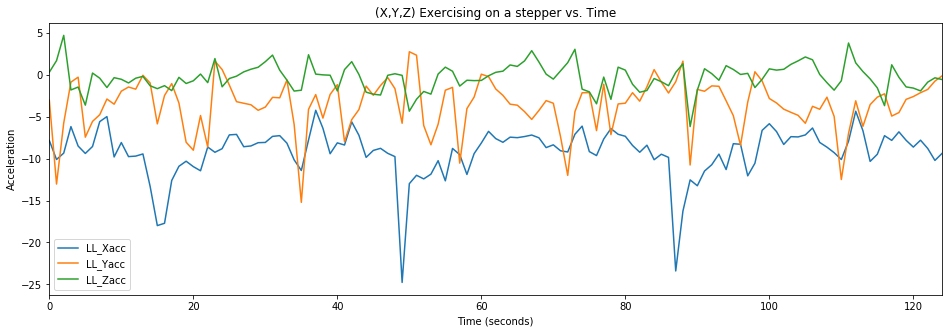

In [4]:
#plotting the data for left leg acceleration
ax = \
df[["LL_Xacc", "LL_Yacc", "LL_Zacc"]].plot(title = "(X,Y,Z) Exercising on a stepper vs. Time",
                                           figsize=(16,5));

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");

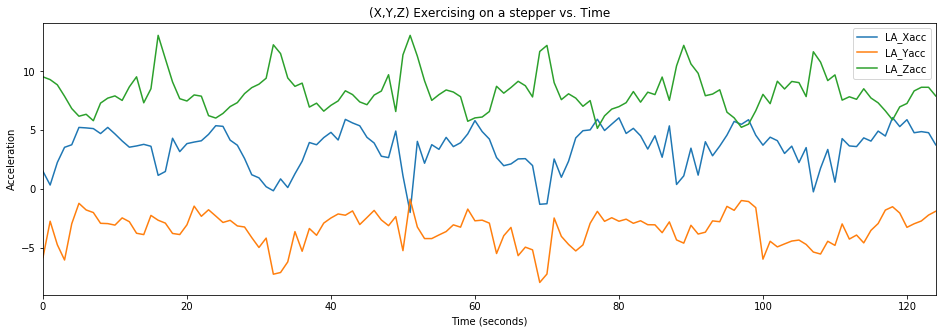

In [5]:
#plotting the data for left arm acceleration
ax = \
df[["LA_Xacc", "LA_Yacc", "LA_Zacc"]].plot(title = "(X,Y,Z) Exercising on a stepper vs. Time",
                                           figsize=(16,5));

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");

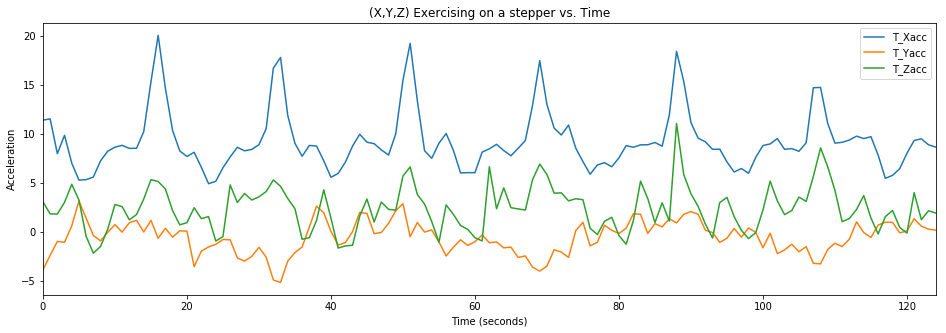

In [6]:
#plotting the data for torso acceleration
ax = \
df[["T_Xacc", "T_Yacc", "T_Zacc"]].plot(title = "(X,Y,Z) Exercising on a stepper vs. Time",
                                           figsize=(16,5));

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");

Note that the vertical dimension is the X direction and the Z direction points away from the device, parallel to the ground.

We can infer from the Z_acc of the left leg and the distance between the peaks that the subject is moving irregularly with short steps. From the right arm plot, we can infer that it's swinging regularly. And the torso plot indicates that there is a regular movement owing to the periodic peaks.

/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


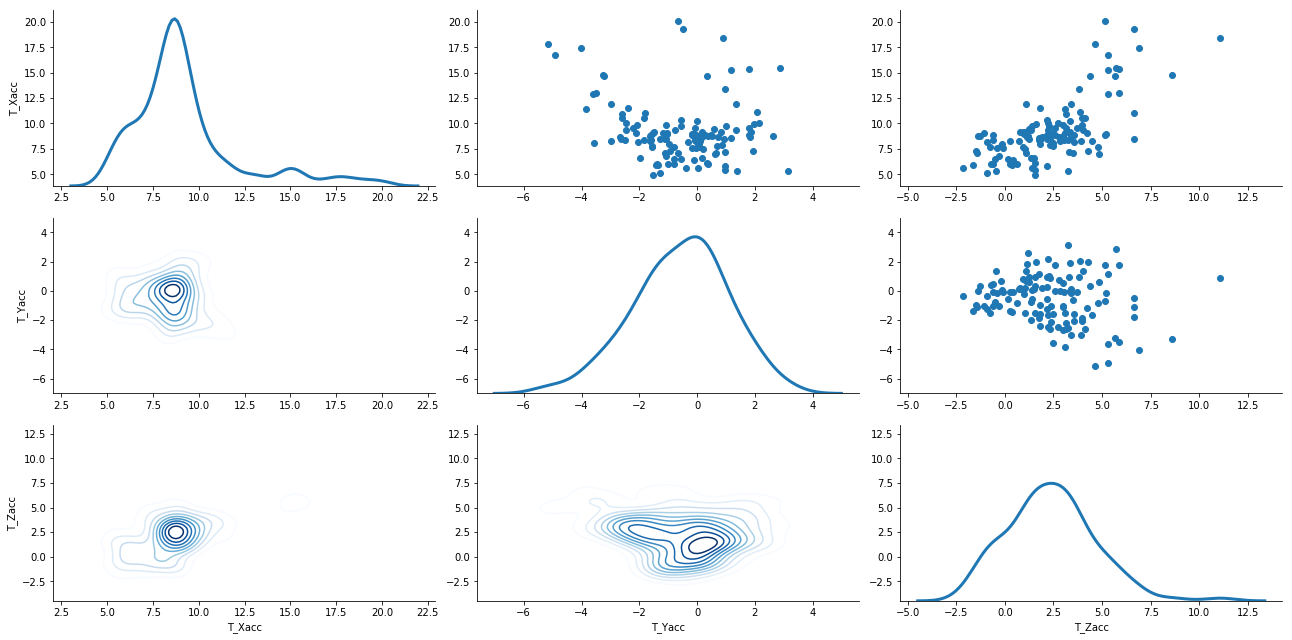

In [7]:
g = sn.PairGrid(df[["T_Xacc", "T_Yacc", "T_Zacc"]], size = 3, aspect = 2.0)
g.map_upper(plt.scatter)
g.map_lower(sn.kdeplot, cmap = "Blues")
g.map_diag(sn.kdeplot, lw = 3, legend = False);

# Experimental work

We can see that the distributions are approximately normal from the diagonal plots.

We will now use feature engineering and append the new features to the signal segments.  
The features are inspired by the approach in Yuksek & Barshan, 2011. Additional features like fthe irst ten values of autocorrelation sequence, mean, variance, skewness, kurtosis and the maximum five peaks of the discrete Fourier transform of a segment with the corresponding frequencies have been extracted.

Each feature is later normalized to a value between 0 and 1 and then flattened into a single row having 1140 features for every 5 second interval.  

Considering all the 5 second segments of every activity for all the  subjects, we obtain 9,120(= 60 segments×19 activities×8 subjects) feature vectors.  

Since the initial number of feature vectors is quite large and not all features are equally useful in discriminating between activities, Principle Component Analysis (PCA) is used for reducing the number of features  to 30. This helps us avoid the Curse of Dimensionality.

**Autocorrelation:**  

It is the correlation of a signal with a delayed copy of itself as a function of delay. In time series data, autocorrelation in a variable of interest is typically modeled either with an autoregressive model (AR), a moving average model (MA), their combination as an autoregressive moving average model (ARMA), or an extension of the latter called an autoregressive integrated moving average model (ARIMA).  It is desirable to minimize autocorrelation so as to transform the series into a stationary state. We can see in the plot for the torso acceleration on a stepper that most of the spikes are statistically insignificant.

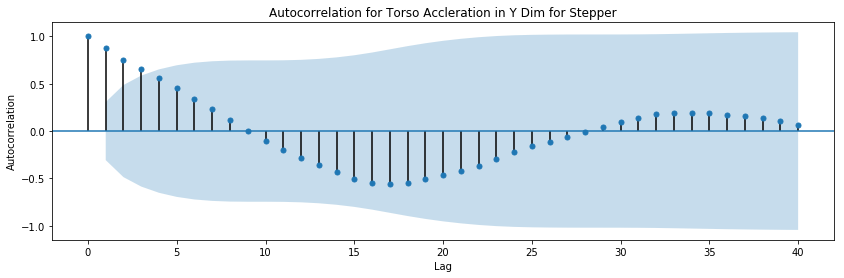

In [8]:
#plotting autocorrelation
x = [ val[0] for val in df[["T_Yacc"]].values.tolist()]
auto = acf(x)

fig, ax = plt.subplots(figsize=(14,4))
title="Autocorrelation for Torso Accleration in Y Dim for Stepper"
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")
plot_acf(auto, ax=ax, title=title);

We have used the first ten points because each physical activity will have a unique sequence. Here is another plot of a subject playing basketball.

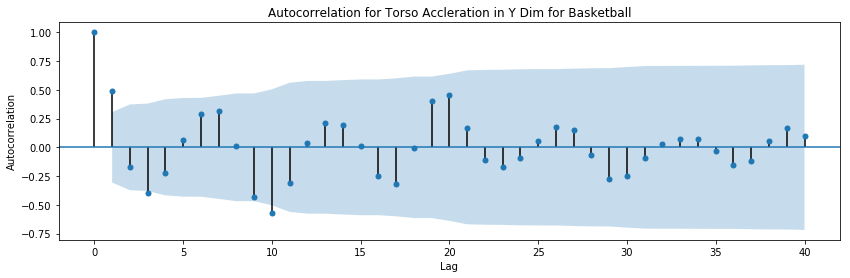

In [9]:
data = "/a19/p1/"

file = segment_names(path, data)
play = path + data + file[0]
df2 = pd.read_csv(play, names = names)


x2 = [ val[0] for val in df2[["T_Yacc"]].values.tolist()]
auto_x = acf(x2)

fig, ax = plt.subplots(figsize=(14,4))
title="Autocorrelation for Torso Accleration in Y Dim for Basketball"
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")
plot_acf(auto_x, ax=ax, title=title);

**Discrete Fourier Transform:**  

DFT provides a nice tool to represent the discrete time signal into periodic Fourier series. The original signal **$ x(t_n) $** can be represented by  

**$ x(t_n) = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} X_k \cdot e^{i 2 \pi k n / N}, 
\quad n\in\mathbb{Z}\ $ **   

where the coefficients of Fourier series $ X_k $ are defined as  

** $ X_k = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} x(t_n) \cdot e^{-i 2 \pi k n / N}, \quad k\in\mathbb{Z}\ $ **   

The curves with the highest frequency are responsible for the macro-oscillations, while the numerous small frequency curves are responsible for the micro-oscillations. These macro-oscillations are responsbile for the general shape of the curve. Each activity will have a different general shape for its signal. By capturing these influential frequencies, our machine learning models will be better able to distinguish between activities.


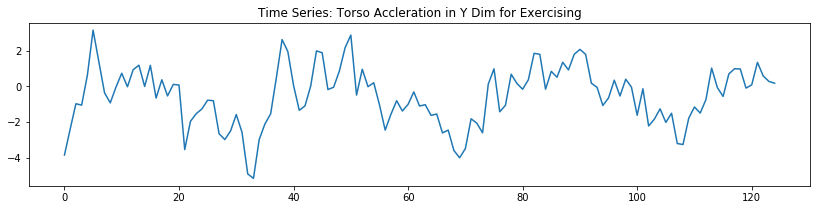

In [10]:
#plotting the time series 
plt.figure(figsize=(14,3))
plt.title("Time Series: Torso Accleration in Y Dim for Exercising")
plt.plot(x);

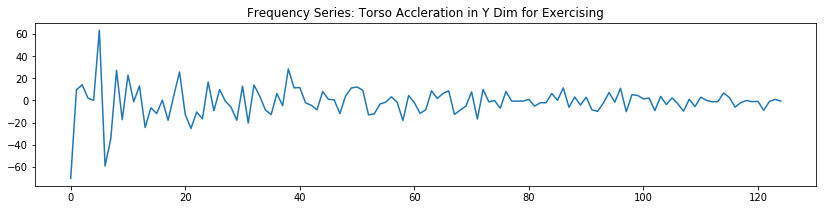

In [11]:
#plotting the frequency series
plt.figure(figsize=(14,3))
plt.title("Frequency Series: Torso Accleration in Y Dim for Exercising")
plt.plot(rfft(x));

**Skewness:**  

It is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined.

**Kurtosis:**  

Kurtosis is a statistical measure that's used to describe the distribution, or skewness, of observed data around the mean, sometimes referred to as the volatility of volatility.

We will use the following functions to extract the new features

In [12]:
#Returns the autocorralation for each of the original 45 features
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

#Returns the extracted features for each of the original 45 features
def get_segment_features(data):
    mean = np.mean(data)
    std = np.std(data)
    kurtosis = stats.kurtosis(data)
    skew = stats.skew(data)
    autocorr_vals = autocorr(data)[0:10].tolist()
    n_max_peaks = 5 # get top n max points to include to features
    n_outlier = 0 # first point is always a large and non-characteristic of the transform
    max_peaks_fft = np.sort(rfft(data))[:-n_outlier][-n_max_peaks:].tolist()
    
    max_peaks_fft.extend([mean, std, skew, kurtosis])
    max_peaks_fft.extend(autocorr_vals)
    
    return max_peaks_fft

#Append the extracted fetures to each of the original 45 features
def expand_features(df, label):
    data = df.T.values.tolist()
    extracted_features = [get_segment_features(row) for row in data]
    
    n_row = df.T.shape[0] 
    for row_i in range(n_row):
        data[row_i].extend(extracted_features[row_i])
        
    data = np.array(data).flatten()
    data = data.tolist()
    data.append(label)
    return data

#Creates activity file names
def get_activity_files_names():
    activity_files = []
    for num in np.arange(1,20,1):
        if num < 10:
            activity_files.append("a0{}".format(num))
        else:
            activity_files.append("a{}".format(num))
    return activity_files

#Creates segment file names
def get_segment_files_names():
    segment_files = []
    for num in np.arange(1,61,1):
        if num < 10:
            segment_files.append("s0{}.txt".format(num))
        else:
            segment_files.append("s{}.txt".format(num))
    return segment_files

#Loads the data, extracts the features, and transforms the data
def transform_data(activity_files, person_files, segment_files):
    player_data = defaultdict(list)
    # for activity_i
    for act_i, activity in enumerate(activity_files):
        act_i += 1
        # for person_j
        for per_i, person in enumerate(person_files):
            per_i += 1
            # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                seg_i += 1
                # load segment data
                segment_path = path + activity + "/" + person + "/" + segment
                # put data in dataframe
                df = pd.read_csv(segment_path, header=None)
                # feature expand 5 second segment 
                expanded_data = expand_features(df, act_i)
                # each segment is now a row 
                player_data[per_i].append(expanded_data)   
    return player_data

In [13]:
#get the names of the activity files a01,a02,...,a19
activity_files = get_activity_files_names()
#get the name of the segment files s01,s02,...,s60
segment_files =  get_segment_files_names()
#create the name of the person files p1,p2,..,p8
person_files = ["p{}".format(num) for num in np.arange(1,9,1)]

#transform the data set
player_data = transform_data(activity_files, person_files, segment_files)


In [14]:
#dimensions for a single player
np.array(player_data[1]).shape

(1140, 6256)

In [15]:
#Create the predictor and response data for each player
def seperate_data(player_data):
    Y = []
    X = []
    for player_i in player_data.keys():
        x_temp = []
        y_temp = []

        for row in player_data[player_i]:
            y_temp.append(row[-1])
            x_temp.append(row[:-1])

        Y.append(y_temp)
        X.append(x_temp)

    Y = np.array(Y)
    X = np.array(X)
    return X, Y

In [16]:
X, Y = seperate_data(player_data)

In [17]:
print (X.shape)
print (Y.shape)

(8, 1140, 6255)
(8, 1140)


In [18]:
#signals
print(X[0])
print(X[0].shape)

[[  8.1305       8.1305       8.1604     ...,   0.38490278   0.3816379
    0.37837115]
 [  7.9665       7.9516       7.9889     ...,   0.38716717   0.38390098
    0.38073552]
 [  7.8917       7.9065       7.8692     ...,   0.38418021   0.38104676
    0.37776553]
 ..., 
 [  0.59867      5.3613       6.7669     ...,  19.09410037  18.77282981
   18.46098436]
 [  7.7747       9.7246       8.8291     ...,  16.95340757  16.3149962
   15.63355124]
 [ 11.997        8.3867       7.9651     ...,   6.41732874   6.23261801
    6.05209777]]
(1140, 6255)


In [19]:
#activities
print(Y[0])
print(Y[0].shape)

[ 1  1  1 ..., 19 19 19]
(1140,)


**Normalize all features between 0 and 1**

In [20]:
scaled_data = np.array([minmax_scale(X[i]) for i in np.arange(0, 8, 1)])

**Apply Principal Component Analysis**

In [21]:
pca = PCA()
# fit pca to the data of a single player for visual purposes
pca.fit(scaled_data[0]);

Let's look at the variance explained by each dimension

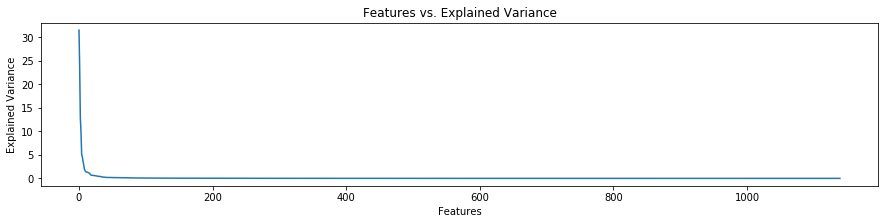

In [22]:
plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_);

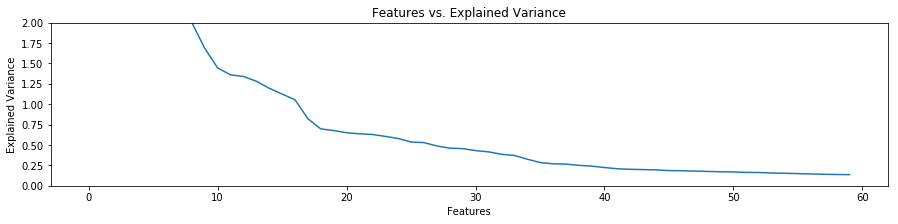

In [23]:
plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_[:60]);
plt.ylim(0,2);

We see that after the $ 40^{th} $ dimension, the explained variance hardly changes.

As suggested in the research paper, we reduce the number of dimensions to 30

In [24]:
#first 30 pca vectors
pca = PCA(n_components=30)
reduced_data = np.array([pca.fit_transform(person_i) for person_i in scaled_data])

In [25]:
#8 subjects, 1140 samples, 30 features
reduced_data.shape

(8, 1140, 30)

# Predictions  

We are now ready to make our predictions and compare different classifier models. First, we will concatenate all the data and split it into training,  testing and validation sets.

In [26]:
#concatenate user data
def attach_user_data(lst):
    data = []
    for row in lst:
        data.extend(row)
    return np.array(data)

X_clean = attach_user_data(reduced_data)
Y_clean = attach_user_data(Y)

print(X_clean.shape)
print(Y_clean.shape)

(9120, 30)
(9120,)


In [27]:
#split data into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=42)

## Classifiers:

We will be comparing the following classifiers:

1.  **Support Vector Machines:**
A support vector machine constructs a hyperplane or set of hyperplanes in a high dimensional space, which can be used for classification, regression, or other tasks like outliers detection. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.  

We have used a one-vs-rest strategy here. It involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. 



In [28]:
#training our model
classifier = OneVsRestClassifier(svm.SVC(random_state=42))
classifier.fit(X_train, Y_train)

#making predictions
Y_pred = classifier.predict(X_test)


Let's evaluate how our model has performed. For that, we will be calculating the precision, recall and $ F_1 $ score.

**Precision:**  

Precision ($ P $) is defined as the number of true positives ($ T_p $) over the number of true positives plus the number of false positives ($ F_p $).

$ P =  \frac{T_p}{T_p+F_p} $

**Recall:**  

Recall ($ R $) is defined as the number of true positives ($ T_p $) over the number of true positives plus the number of false negatives ($ F_n $).

$ R = \frac{T_p}{T_p + F_n} $

**$ F_1 $ Score:**  

It is defined as the harmonic mean of precision and recall.

$ F_1 = 2\frac{P \times R}{P+R} $

In [29]:
#evaluating scores
precision_recall_fscore_support(Y_test, Y_pred, average='micro')

(0.98793859649122806, 0.98793859649122806, 0.98793859649122806, None)

So we see that our model has an impressive $ F_1 $ score of $ 0.987 $.  
Let us visualize it better with a heat map.

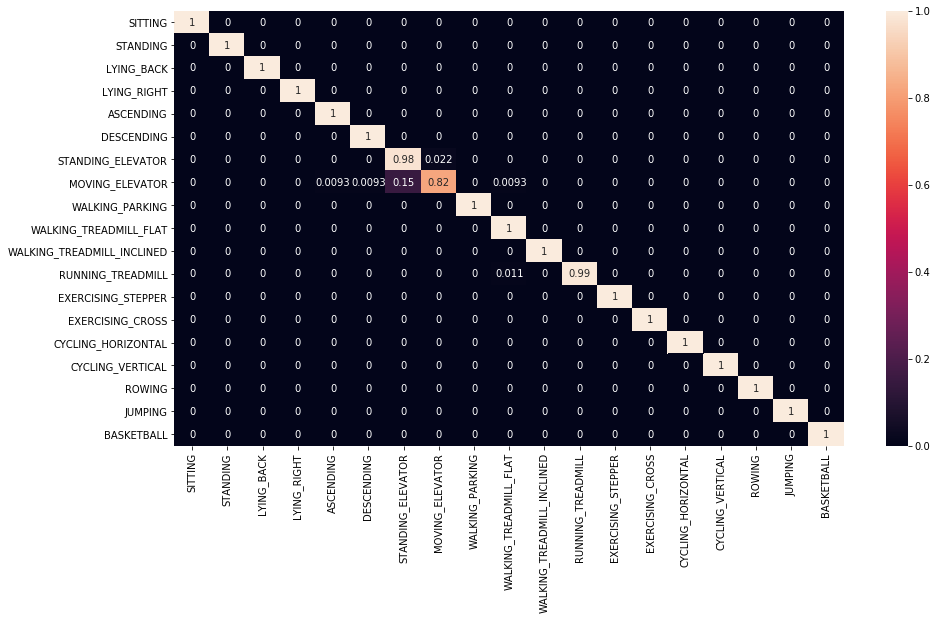

In [30]:
def hmap(test, pred):
    cm = confusion_matrix(test, pred)
    cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) #normalization
    np.set_printoptions(precision=2)
    df_cm = pd.DataFrame(cm, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
    plt.figure(figsize = (15,8))
    sn.heatmap(df_cm, annot=True)
    
hmap(Y_test, Y_pred)

The Y-axis represents the actual classes while the X-axis represents the classes predicted by our classifier.

  2 . **Quadratic Discriminant Analysis:**  
  It is a type of Bayesian classifier. It is used to separate measurements of two or more classes of objects or events by a  quadric surface. It is a more general version of the linear classifier. Unlike LDA however, in QDA there is no assumption that the covariance of each of the classes is identical. When the normality assumption is true, the best possible test for the hypothesis that a given measurement is from a given class is the likelihood ratio test. 


In [31]:
#training our model
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, Y_train)

#making predictions
Y_prede = clf.predict(X_test)

In [32]:
#evaluating scores
precision_recall_fscore_support(Y_test, Y_prede, average='micro')

(0.97313596491228072, 0.97313596491228072, 0.97313596491228072, None)

That's a high score.  Let us look at the heat map.

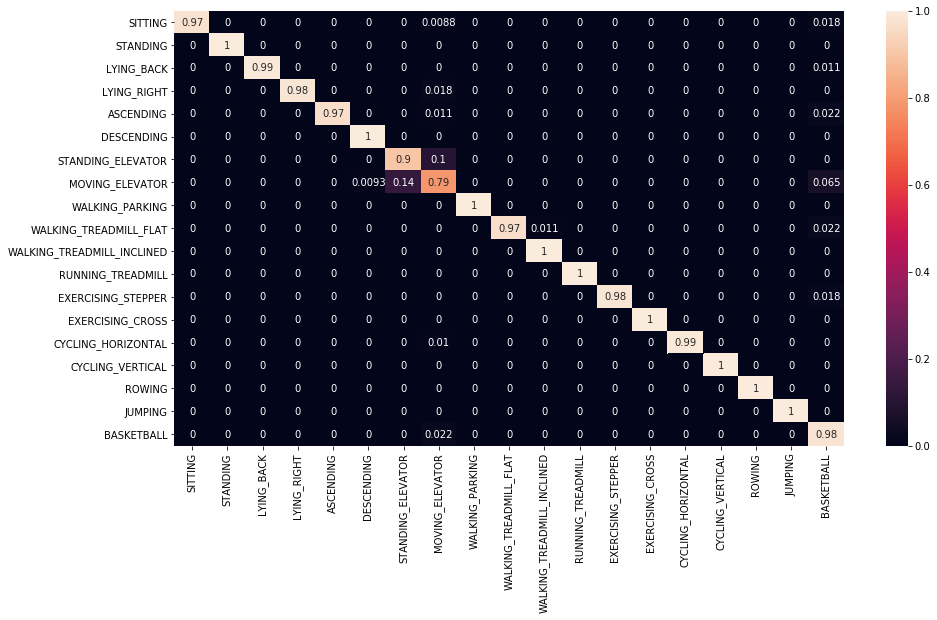

In [33]:
hmap(Y_test, Y_prede)

3 . **Random Forest:**  
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

In [36]:
#training our model
clf = RandomForestClassifier(max_depth = 20, random_state = 42, n_estimators = 12, min_samples_split=3,
                            min_samples_leaf=4)
clf.fit(X_train, Y_train)

#making predictions
Y_predee = clf.predict(X_test)

In [37]:
#calculating scores
precision_recall_fscore_support(Y_test, Y_predee, average='micro')

(0.96875, 0.96875, 0.96875, None)

Now we'll see the heat map

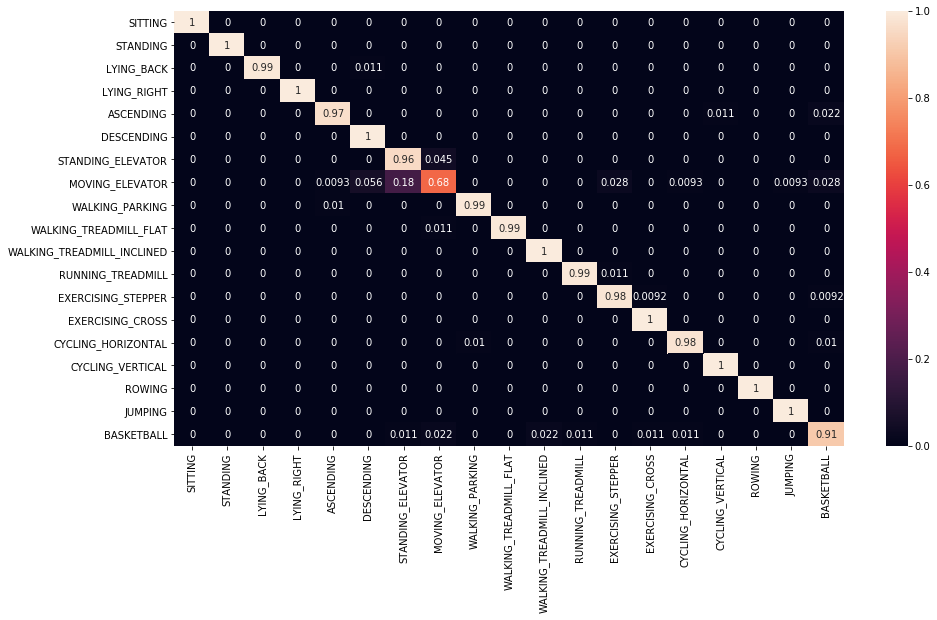

In [38]:
hmap(Y_test, Y_predee)

 4 . **K Nearest Neighbour:**  
In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In [39]:
#training our model
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, Y_train)

#making predictions
Y_predi = clf.predict(X_test)

In [40]:
#evaluating the model
precision_recall_fscore_support(Y_test, Y_predi, average='micro')

(0.97423245614035092, 0.97423245614035092, 0.97423245614035092, None)

We have achieved a $ F_1 $ score of $ 0.9742 $. The heatmap is as follows:

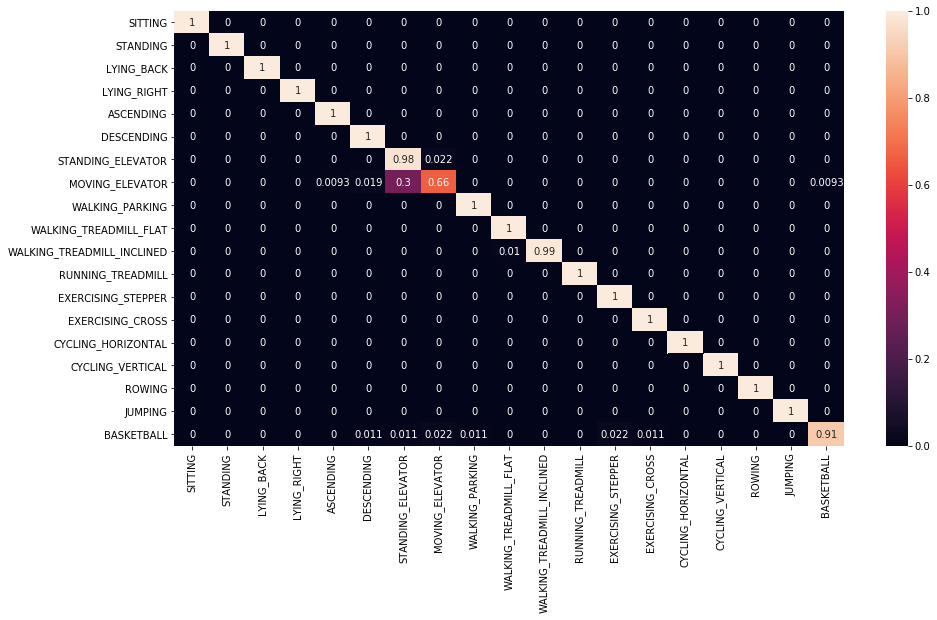

In [41]:
hmap(Y_test, Y_predi)

**5 . Neural Networks:**  
We will use two approaches here. First, we will use feature engineered data for our predictions. Next time, we will use the raw data for our predictions.

**A. Feature engineered data: **    
First, we will divide the the training set into training and validation set.

In [42]:
#split training into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [43]:
def adjust(y):
    for i in range(len(y)):
        y[i]-=1
    return y

Y_train = adjust(Y_train)
Y_test = adjust(Y_test)
Y_val = adjust(Y_val)


Now we will convert the output vectors into one hot encoding

In [44]:
#convert to one hot encoding
def int_to_one_hot(y):
    y2 = np.max(y) + 1
    return np.eye(y2)[y]

Y_train2 = int_to_one_hot(Y_train)
Y_val2 = int_to_one_hot(Y_val)
Y_test2 = int_to_one_hot(Y_test)

Since Keras does not yet support an in built $ F_1 $ scorer, we will write our custom method.

In [45]:
#calculate f1 score
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 2 * precision * recall / ( precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

#plotting 
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Now, we will create a simple neural network. The architecture is:  
1 . Input layer taking 30 features after reduction  
2 . The first hidden layer has 30 neurons with ReLU as the activation function.  
3 . The second hidden layer has 64 neurons with ReLU as the activation function.
4 . The last hidden layer has 72 neurons with ReLU as the activation function.
5 . The output layer has 19 neurons for multiclassification and uses the softmax function.

We will conduct some experiments to decide upon our hyperparameters 

We will first run the model without dropout and using RMSprop as the optimiser

In [46]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

# Fit the model
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=200, batch_size=64)
end = time.time()


Train on 5836 samples, validate on 1460 samples
Epoch 1/200
5836/5836 [==============================] - 0s 61us/step - loss: 2.3694 - acc: 0.2993 - f1_score: 0.0353 - val_loss: 1.9669 - val_acc: 0.4486 - val_f1_score: 0.0603
Epoch 2/200
5836/5836 [==============================] - 0s 34us/step - loss: 1.6219 - acc: 0.5452 - f1_score: 0.1797 - val_loss: 1.3818 - val_acc: 0.5979 - val_f1_score: 0.2733
Epoch 3/200
5836/5836 [==============================] - 0s 34us/step - loss: 1.1136 - acc: 0.7099 - f1_score: 0.3787 - val_loss: 0.9743 - val_acc: 0.7479 - val_f1_score: 0.4514
Epoch 4/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.7471 - acc: 0.8165 - f1_score: 0.5876 - val_loss: 0.6774 - val_acc: 0.8219 - val_f1_score: 0.6425
Epoch 5/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.5171 - acc: 0.8756 - f1_score: 0.7526 - val_loss: 0.4807 - val_acc: 0.8747 - val_f1_score: 0.7842
Epoch 6/200
5836/5836 [==============================] - 0s 34

Epoch 92/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.0043 - acc: 0.9983 - f1_score: 0.9983 - val_loss: 0.1274 - val_acc: 0.9747 - val_f1_score: 0.9747
Epoch 93/200
5836/5836 [==============================] - 0s 32us/step - loss: 0.0042 - acc: 0.9981 - f1_score: 0.9981 - val_loss: 0.1256 - val_acc: 0.9740 - val_f1_score: 0.9733
Epoch 94/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.0046 - acc: 0.9983 - f1_score: 0.9983 - val_loss: 0.1275 - val_acc: 0.9726 - val_f1_score: 0.9726
Epoch 95/200
5836/5836 [==============================] - 0s 34us/step - loss: 0.0043 - acc: 0.9983 - f1_score: 0.9983 - val_loss: 0.1346 - val_acc: 0.9753 - val_f1_score: 0.9753
Epoch 96/200
5836/5836 [==============================] - 0s 34us/step - loss: 0.0048 - acc: 0.9985 - f1_score: 0.9985 - val_loss: 0.1407 - val_acc: 0.9747 - val_f1_score: 0.9747
Epoch 97/200
5836/5836 [==============================] - 0s 32us/step - loss: 0.0037 - acc: 0.9981 - f1_

5836/5836 [==============================] - 0s 32us/step - loss: 0.0022 - acc: 0.9993 - f1_score: 0.9993 - val_loss: 0.1990 - val_acc: 0.9753 - val_f1_score: 0.9747
Epoch 183/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.0017 - acc: 0.9995 - f1_score: 0.9995 - val_loss: 0.1790 - val_acc: 0.9774 - val_f1_score: 0.9774
Epoch 184/200
5836/5836 [==============================] - 0s 32us/step - loss: 0.0036 - acc: 0.9991 - f1_score: 0.9991 - val_loss: 0.1779 - val_acc: 0.9767 - val_f1_score: 0.9767
Epoch 185/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.0025 - acc: 0.9995 - f1_score: 0.9995 - val_loss: 0.1923 - val_acc: 0.9753 - val_f1_score: 0.9753
Epoch 186/200
5836/5836 [==============================] - 0s 32us/step - loss: 0.0025 - acc: 0.9991 - f1_score: 0.9991 - val_loss: 0.2076 - val_acc: 0.9733 - val_f1_score: 0.9733
Epoch 187/200
5836/5836 [==============================] - 0s 33us/step - loss: 0.0022 - acc: 0.9993 - f1_score: 0

Model took 38.69 seconds to train


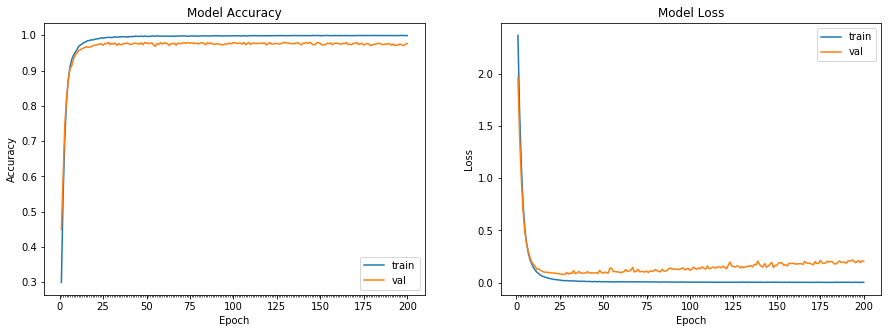

In [47]:
print("Model took %0.2f seconds to train"%(end - start))

plot_model_history(model_info)

Let us now test the model against our test set.

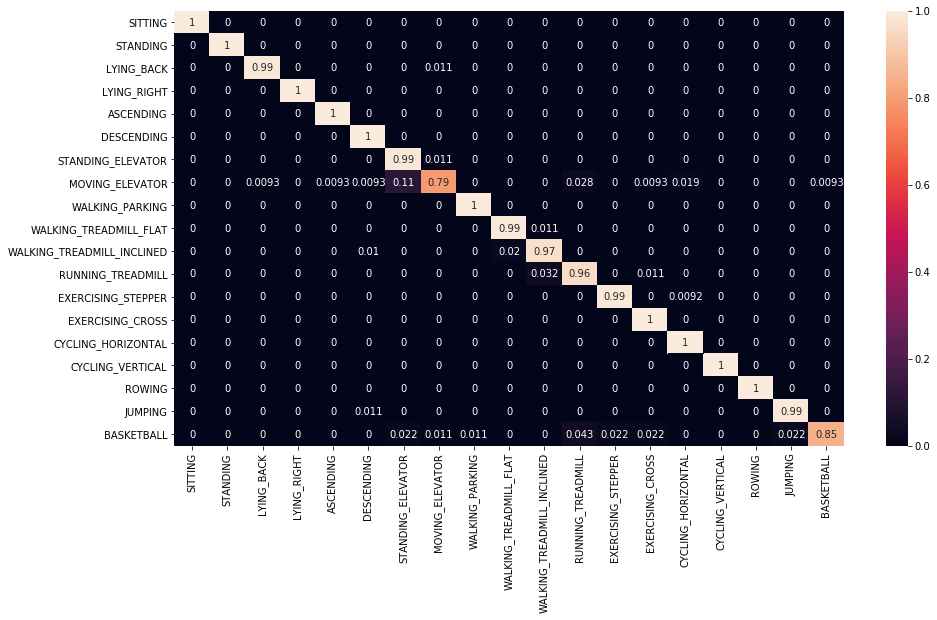

In [48]:
#predicting
prediction = np.argmax(model.predict(x = X_test, batch_size=64), axis=1)

#plotting
hmap(Y_test, prediction)

Now let's try it again but this time with dropout.'

In [49]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

# Fit the model
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=200, batch_size=64)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/200
5836/5836 [==============================] - 0s 74us/step - loss: 2.4735 - acc: 0.2796 - f1_score: 0.0250 - val_loss: 1.9798 - val_acc: 0.4705 - val_f1_score: 0.0966
Epoch 2/200
5836/5836 [==============================] - 0s 38us/step - loss: 1.6659 - acc: 0.5418 - f1_score: 0.1878 - val_loss: 1.3519 - val_acc: 0.6274 - val_f1_score: 0.2877
Epoch 3/200
5836/5836 [==============================] - 0s 39us/step - loss: 1.1222 - acc: 0.7005 - f1_score: 0.3987 - val_loss: 0.9262 - val_acc: 0.7582 - val_f1_score: 0.4890
Epoch 4/200
5836/5836 [==============================] - 0s 37us/step - loss: 0.7633 - acc: 0.8050 - f1_score: 0.5913 - val_loss: 0.6331 - val_acc: 0.8342 - val_f1_score: 0.6781
Epoch 5/200
5836/5836 [==============================] - 0s 38us/step - loss: 0.5383 - acc: 0.8701 - f1_score: 0.7389 - val_loss: 0.4696 - val_acc: 0.8719 - val_f1_score: 0.7664
Epoch 6/200
5836/5836 [==============================] - 0s 37

Epoch 92/200
5836/5836 [==============================] - 0s 39us/step - loss: 0.0170 - acc: 0.9943 - f1_score: 0.9942 - val_loss: 0.0811 - val_acc: 0.9788 - val_f1_score: 0.9774
Epoch 93/200
5836/5836 [==============================] - 0s 39us/step - loss: 0.0242 - acc: 0.9930 - f1_score: 0.9926 - val_loss: 0.1010 - val_acc: 0.9719 - val_f1_score: 0.9719
Epoch 94/200
5836/5836 [==============================] - 0s 38us/step - loss: 0.0260 - acc: 0.9923 - f1_score: 0.9921 - val_loss: 0.0806 - val_acc: 0.9774 - val_f1_score: 0.9760
Epoch 95/200
5836/5836 [==============================] - 0s 37us/step - loss: 0.0224 - acc: 0.9945 - f1_score: 0.9945 - val_loss: 0.0849 - val_acc: 0.9795 - val_f1_score: 0.9795
Epoch 96/200
5836/5836 [==============================] - 0s 38us/step - loss: 0.0237 - acc: 0.9940 - f1_score: 0.9937 - val_loss: 0.0657 - val_acc: 0.9801 - val_f1_score: 0.9788
Epoch 97/200
5836/5836 [==============================] - 0s 38us/step - loss: 0.0232 - acc: 0.9942 - f1_

5836/5836 [==============================] - 0s 38us/step - loss: 0.0145 - acc: 0.9961 - f1_score: 0.9959 - val_loss: 0.1125 - val_acc: 0.9774 - val_f1_score: 0.9767
Epoch 183/200
5836/5836 [==============================] - 0s 39us/step - loss: 0.0118 - acc: 0.9961 - f1_score: 0.9961 - val_loss: 0.0847 - val_acc: 0.9781 - val_f1_score: 0.9781
Epoch 184/200
5836/5836 [==============================] - 0s 39us/step - loss: 0.0169 - acc: 0.9945 - f1_score: 0.9945 - val_loss: 0.0919 - val_acc: 0.9822 - val_f1_score: 0.9822
Epoch 185/200
5836/5836 [==============================] - 0s 38us/step - loss: 0.0168 - acc: 0.9959 - f1_score: 0.9959 - val_loss: 0.0962 - val_acc: 0.9788 - val_f1_score: 0.9781
Epoch 186/200
5836/5836 [==============================] - 0s 38us/step - loss: 0.0188 - acc: 0.9952 - f1_score: 0.9950 - val_loss: 0.1157 - val_acc: 0.9788 - val_f1_score: 0.9788
Epoch 187/200
5836/5836 [==============================] - 0s 36us/step - loss: 0.0184 - acc: 0.9943 - f1_score: 0

Model took 44.54 seconds to train


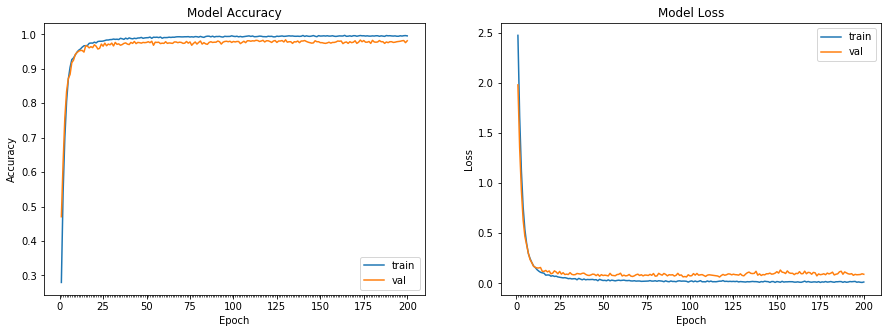

In [50]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

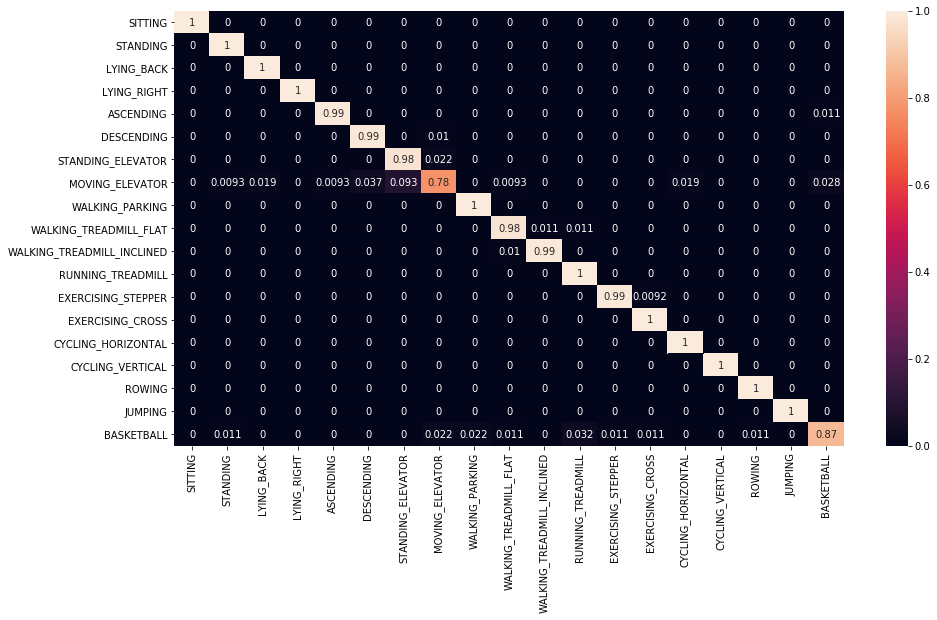

In [51]:
#predicting
prediction = np.argmax(model.predict(x = X_test, batch_size=64), axis=1)

#plotting
hmap(Y_test, prediction)

The model took longer to train but there has been a decrease in the model loss. We also see that the accuracy increases as the number of epochs increases. Let's try increasing the number of epochs.

In [54]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

# Fit the model
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=300, batch_size=64)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 1s 87us/step - loss: 2.5128 - acc: 0.2461 - f1_score: 0.0260 - val_loss: 2.0152 - val_acc: 0.3973 - val_f1_score: 0.0815
Epoch 2/300
5836/5836 [==============================] - 0s 39us/step - loss: 1.6544 - acc: 0.5243 - f1_score: 0.1607 - val_loss: 1.3662 - val_acc: 0.5863 - val_f1_score: 0.2589
Epoch 3/300
5836/5836 [==============================] - 0s 39us/step - loss: 1.1115 - acc: 0.7108 - f1_score: 0.3708 - val_loss: 0.9569 - val_acc: 0.7308 - val_f1_score: 0.4705
Epoch 4/300
5836/5836 [==============================] - 0s 39us/step - loss: 0.7561 - acc: 0.8155 - f1_score: 0.5920 - val_loss: 0.6446 - val_acc: 0.8377 - val_f1_score: 0.6781
Epoch 5/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.5251 - acc: 0.8669 - f1_score: 0.7502 - val_loss: 0.4610 - val_acc: 0.8856 - val_f1_score: 0.8123
Epoch 6/300
5836/5836 [==============================] - 0s 39

Epoch 92/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0230 - acc: 0.9926 - f1_score: 0.9925 - val_loss: 0.0685 - val_acc: 0.9808 - val_f1_score: 0.9801
Epoch 93/300
5836/5836 [==============================] - 0s 40us/step - loss: 0.0153 - acc: 0.9952 - f1_score: 0.9949 - val_loss: 0.0865 - val_acc: 0.9760 - val_f1_score: 0.9760
Epoch 94/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0222 - acc: 0.9935 - f1_score: 0.9933 - val_loss: 0.0664 - val_acc: 0.9822 - val_f1_score: 0.9822
Epoch 95/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0136 - acc: 0.9954 - f1_score: 0.9950 - val_loss: 0.0724 - val_acc: 0.9788 - val_f1_score: 0.9781
Epoch 96/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0173 - acc: 0.9937 - f1_score: 0.9937 - val_loss: 0.0798 - val_acc: 0.9781 - val_f1_score: 0.9781
Epoch 97/300
5836/5836 [==============================] - 0s 39us/step - loss: 0.0178 - acc: 0.9954 - f1_

5836/5836 [==============================] - 0s 39us/step - loss: 0.0082 - acc: 0.9973 - f1_score: 0.9973 - val_loss: 0.0788 - val_acc: 0.9822 - val_f1_score: 0.9815
Epoch 183/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0180 - acc: 0.9942 - f1_score: 0.9940 - val_loss: 0.0838 - val_acc: 0.9788 - val_f1_score: 0.9781
Epoch 184/300
5836/5836 [==============================] - 0s 37us/step - loss: 0.0106 - acc: 0.9964 - f1_score: 0.9964 - val_loss: 0.0670 - val_acc: 0.9836 - val_f1_score: 0.9836
Epoch 185/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0119 - acc: 0.9967 - f1_score: 0.9967 - val_loss: 0.0813 - val_acc: 0.9801 - val_f1_score: 0.9801
Epoch 186/300
5836/5836 [==============================] - 0s 37us/step - loss: 0.0092 - acc: 0.9971 - f1_score: 0.9969 - val_loss: 0.0994 - val_acc: 0.9781 - val_f1_score: 0.9774
Epoch 187/300
5836/5836 [==============================] - 0s 37us/step - loss: 0.0129 - acc: 0.9967 - f1_score: 0

5836/5836 [==============================] - 0s 39us/step - loss: 0.0193 - acc: 0.9957 - f1_score: 0.9955 - val_loss: 0.1043 - val_acc: 0.9808 - val_f1_score: 0.9808
Epoch 273/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0175 - acc: 0.9957 - f1_score: 0.9955 - val_loss: 0.1263 - val_acc: 0.9767 - val_f1_score: 0.9767
Epoch 274/300
5836/5836 [==============================] - 0s 39us/step - loss: 0.0101 - acc: 0.9967 - f1_score: 0.9967 - val_loss: 0.1035 - val_acc: 0.9767 - val_f1_score: 0.9767
Epoch 275/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0185 - acc: 0.9957 - f1_score: 0.9957 - val_loss: 0.1077 - val_acc: 0.9788 - val_f1_score: 0.9788
Epoch 276/300
5836/5836 [==============================] - 0s 39us/step - loss: 0.0103 - acc: 0.9969 - f1_score: 0.9969 - val_loss: 0.1030 - val_acc: 0.9774 - val_f1_score: 0.9774
Epoch 277/300
5836/5836 [==============================] - 0s 38us/step - loss: 0.0125 - acc: 0.9962 - f1_score: 0

Model took 67.94 seconds to train


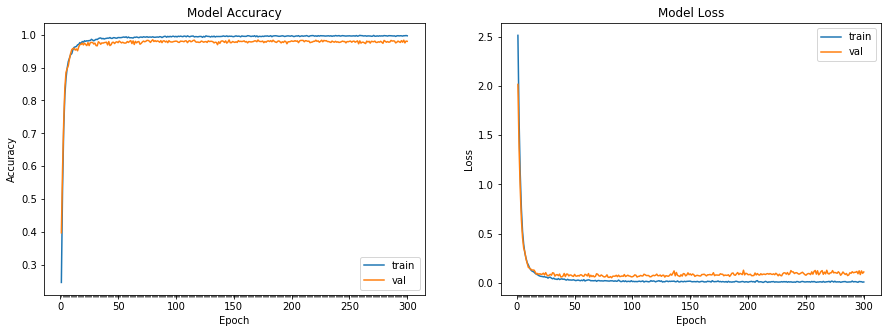

In [55]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

As we can see, there is an increase in accuracy with a decrease in the loss with increasing epochs.  

Now, we'll try varying the batch size.

In [56]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

# Fit the model with increased batch size
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=300, batch_size=128)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 0s 75us/step - loss: 2.6126 - acc: 0.2166 - f1_score: 0.0170 - val_loss: 2.2308 - val_acc: 0.3582 - val_f1_score: 0.0534
Epoch 2/300
5836/5836 [==============================] - 0s 23us/step - loss: 1.9685 - acc: 0.4568 - f1_score: 0.0763 - val_loss: 1.7135 - val_acc: 0.5205 - val_f1_score: 0.1623
Epoch 3/300
5836/5836 [==============================] - 0s 23us/step - loss: 1.5061 - acc: 0.5857 - f1_score: 0.2392 - val_loss: 1.3494 - val_acc: 0.6288 - val_f1_score: 0.3212
Epoch 4/300
5836/5836 [==============================] - 0s 24us/step - loss: 1.1663 - acc: 0.6904 - f1_score: 0.3775 - val_loss: 1.0567 - val_acc: 0.7116 - val_f1_score: 0.4288
Epoch 5/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.9008 - acc: 0.7810 - f1_score: 0.5017 - val_loss: 0.8353 - val_acc: 0.7925 - val_f1_score: 0.5521
Epoch 6/300
5836/5836 [==============================] - 0s 23

Epoch 92/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0212 - acc: 0.9938 - f1_score: 0.9933 - val_loss: 0.0716 - val_acc: 0.9801 - val_f1_score: 0.9801
Epoch 93/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0232 - acc: 0.9928 - f1_score: 0.9926 - val_loss: 0.0877 - val_acc: 0.9774 - val_f1_score: 0.9767
Epoch 94/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0180 - acc: 0.9940 - f1_score: 0.9940 - val_loss: 0.0767 - val_acc: 0.9788 - val_f1_score: 0.9788
Epoch 95/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0185 - acc: 0.9949 - f1_score: 0.9945 - val_loss: 0.0978 - val_acc: 0.9781 - val_f1_score: 0.9774
Epoch 96/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0189 - acc: 0.9940 - f1_score: 0.9935 - val_loss: 0.0786 - val_acc: 0.9808 - val_f1_score: 0.9801
Epoch 97/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0225 - acc: 0.9933 - f1_

5836/5836 [==============================] - 0s 24us/step - loss: 0.0129 - acc: 0.9952 - f1_score: 0.9952 - val_loss: 0.0962 - val_acc: 0.9795 - val_f1_score: 0.9795
Epoch 183/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0137 - acc: 0.9964 - f1_score: 0.9964 - val_loss: 0.0943 - val_acc: 0.9788 - val_f1_score: 0.9788
Epoch 184/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0183 - acc: 0.9945 - f1_score: 0.9942 - val_loss: 0.0817 - val_acc: 0.9815 - val_f1_score: 0.9815
Epoch 185/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0118 - acc: 0.9966 - f1_score: 0.9966 - val_loss: 0.0876 - val_acc: 0.9815 - val_f1_score: 0.9815
Epoch 186/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0114 - acc: 0.9959 - f1_score: 0.9955 - val_loss: 0.0963 - val_acc: 0.9808 - val_f1_score: 0.9808
Epoch 187/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0103 - acc: 0.9961 - f1_score: 0

5836/5836 [==============================] - 0s 23us/step - loss: 0.0093 - acc: 0.9969 - f1_score: 0.9967 - val_loss: 0.0971 - val_acc: 0.9808 - val_f1_score: 0.9808
Epoch 273/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0114 - acc: 0.9957 - f1_score: 0.9957 - val_loss: 0.1063 - val_acc: 0.9788 - val_f1_score: 0.9788
Epoch 274/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0157 - acc: 0.9952 - f1_score: 0.9952 - val_loss: 0.1217 - val_acc: 0.9767 - val_f1_score: 0.9760
Epoch 275/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0094 - acc: 0.9967 - f1_score: 0.9967 - val_loss: 0.1051 - val_acc: 0.9795 - val_f1_score: 0.9788
Epoch 276/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0119 - acc: 0.9959 - f1_score: 0.9957 - val_loss: 0.1034 - val_acc: 0.9774 - val_f1_score: 0.9767
Epoch 277/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0131 - acc: 0.9962 - f1_score: 0

Model took 41.67 seconds to train


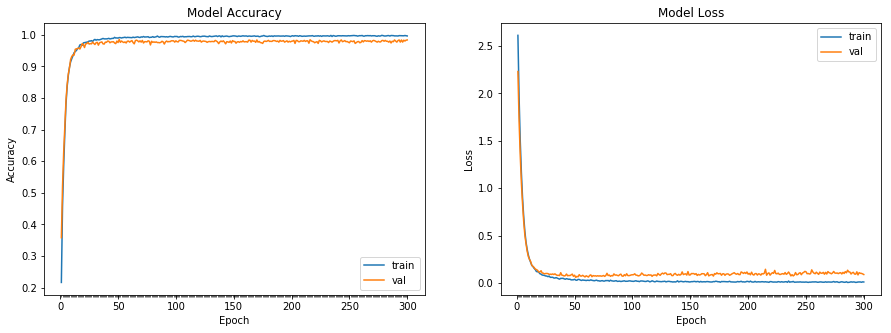

In [57]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

There has been a decrease in the model loss. Now let's try using SGD as our optimiser.

In [58]:
from keras import optimizers

#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1_score])

# Fit the model with increased batch size
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=300, batch_size=128)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 0s 84us/step - loss: 2.7163 - acc: 0.1503 - f1_score: 0.0125 - val_loss: 2.3868 - val_acc: 0.2705 - val_f1_score: 0.0582
Epoch 2/300
5836/5836 [==============================] - 0s 25us/step - loss: 2.1114 - acc: 0.3855 - f1_score: 0.0732 - val_loss: 1.8156 - val_acc: 0.4815 - val_f1_score: 0.1205
Epoch 3/300
5836/5836 [==============================] - 0s 24us/step - loss: 1.5740 - acc: 0.5595 - f1_score: 0.1957 - val_loss: 1.3948 - val_acc: 0.5993 - val_f1_score: 0.2390
Epoch 4/300
5836/5836 [==============================] - 0s 24us/step - loss: 1.1918 - acc: 0.6628 - f1_score: 0.3310 - val_loss: 1.0781 - val_acc: 0.6986 - val_f1_score: 0.3870
Epoch 5/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.9225 - acc: 0.7479 - f1_score: 0.4993 - val_loss: 0.8440 - val_acc: 0.7541 - val_f1_score: 0.5562
Epoch 6/300
5836/5836 [==============================] - 0s 25

Epoch 92/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0343 - acc: 0.9909 - f1_score: 0.9901 - val_loss: 0.0877 - val_acc: 0.9753 - val_f1_score: 0.9747
Epoch 93/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0341 - acc: 0.9907 - f1_score: 0.9902 - val_loss: 0.0935 - val_acc: 0.9740 - val_f1_score: 0.9733
Epoch 94/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0359 - acc: 0.9894 - f1_score: 0.9885 - val_loss: 0.0953 - val_acc: 0.9726 - val_f1_score: 0.9712
Epoch 95/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0338 - acc: 0.9901 - f1_score: 0.9897 - val_loss: 0.1038 - val_acc: 0.9719 - val_f1_score: 0.9705
Epoch 96/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0299 - acc: 0.9925 - f1_score: 0.9913 - val_loss: 0.0916 - val_acc: 0.9726 - val_f1_score: 0.9699
Epoch 97/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0361 - acc: 0.9897 - f1_

5836/5836 [==============================] - 0s 25us/step - loss: 0.0182 - acc: 0.9942 - f1_score: 0.9937 - val_loss: 0.0926 - val_acc: 0.9733 - val_f1_score: 0.9726
Epoch 183/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0199 - acc: 0.9937 - f1_score: 0.9930 - val_loss: 0.0827 - val_acc: 0.9767 - val_f1_score: 0.9760
Epoch 184/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0217 - acc: 0.9933 - f1_score: 0.9931 - val_loss: 0.1073 - val_acc: 0.9740 - val_f1_score: 0.9740
Epoch 185/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0187 - acc: 0.9943 - f1_score: 0.9933 - val_loss: 0.0845 - val_acc: 0.9767 - val_f1_score: 0.9753
Epoch 186/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0169 - acc: 0.9945 - f1_score: 0.9943 - val_loss: 0.0774 - val_acc: 0.9767 - val_f1_score: 0.9753
Epoch 187/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0170 - acc: 0.9952 - f1_score: 0

5836/5836 [==============================] - 0s 25us/step - loss: 0.0147 - acc: 0.9954 - f1_score: 0.9950 - val_loss: 0.1041 - val_acc: 0.9740 - val_f1_score: 0.9733
Epoch 273/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0134 - acc: 0.9954 - f1_score: 0.9950 - val_loss: 0.0812 - val_acc: 0.9808 - val_f1_score: 0.9788
Epoch 274/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0106 - acc: 0.9966 - f1_score: 0.9964 - val_loss: 0.0846 - val_acc: 0.9767 - val_f1_score: 0.9753
Epoch 275/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0140 - acc: 0.9954 - f1_score: 0.9949 - val_loss: 0.0893 - val_acc: 0.9767 - val_f1_score: 0.9760
Epoch 276/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0128 - acc: 0.9971 - f1_score: 0.9971 - val_loss: 0.0906 - val_acc: 0.9781 - val_f1_score: 0.9774
Epoch 277/300
5836/5836 [==============================] - 0s 28us/step - loss: 0.0081 - acc: 0.9973 - f1_score: 0

Model took 45.48 seconds to train


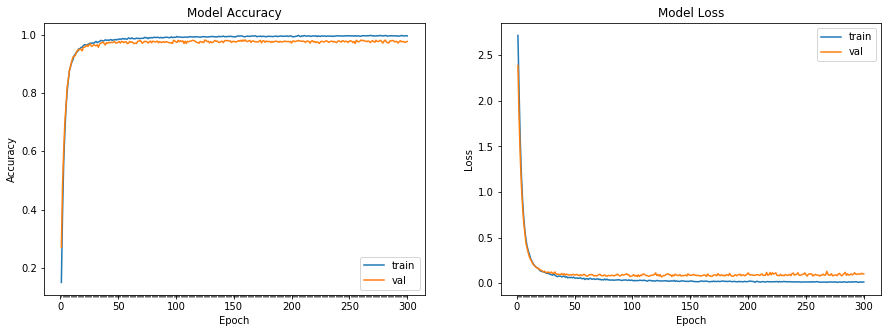

In [59]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

It has a lower performance than our earlier model. Let's try changing the learning rate.

In [60]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

sgd = optimizers.SGD(lr=0.012, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1_score])

# Fit the model with increased batch size
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=300, batch_size=128)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 1s 100us/step - loss: 2.6944 - acc: 0.1828 - f1_score: 0.0156 - val_loss: 2.2664 - val_acc: 0.3185 - val_f1_score: 0.0466
Epoch 2/300
5836/5836 [==============================] - 0s 25us/step - loss: 1.9151 - acc: 0.4390 - f1_score: 0.1225 - val_loss: 1.6338 - val_acc: 0.5158 - val_f1_score: 0.2212
Epoch 3/300
5836/5836 [==============================] - 0s 25us/step - loss: 1.3883 - acc: 0.6004 - f1_score: 0.2889 - val_loss: 1.2187 - val_acc: 0.6397 - val_f1_score: 0.3479
Epoch 4/300
5836/5836 [==============================] - 0s 25us/step - loss: 1.0366 - acc: 0.7212 - f1_score: 0.4256 - val_loss: 0.9177 - val_acc: 0.7616 - val_f1_score: 0.4822
Epoch 5/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.7876 - acc: 0.7928 - f1_score: 0.5653 - val_loss: 0.7078 - val_acc: 0.8205 - val_f1_score: 0.6363
Epoch 6/300
5836/5836 [==============================] - 0s 2

Epoch 92/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0304 - acc: 0.9916 - f1_score: 0.9911 - val_loss: 0.0722 - val_acc: 0.9747 - val_f1_score: 0.9726
Epoch 93/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0339 - acc: 0.9916 - f1_score: 0.9913 - val_loss: 0.0694 - val_acc: 0.9795 - val_f1_score: 0.9788
Epoch 94/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0246 - acc: 0.9937 - f1_score: 0.9931 - val_loss: 0.0696 - val_acc: 0.9801 - val_f1_score: 0.9774
Epoch 95/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0217 - acc: 0.9952 - f1_score: 0.9942 - val_loss: 0.0684 - val_acc: 0.9781 - val_f1_score: 0.9753
Epoch 96/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0258 - acc: 0.9933 - f1_score: 0.9925 - val_loss: 0.0807 - val_acc: 0.9747 - val_f1_score: 0.9733
Epoch 97/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0368 - acc: 0.9902 - f1_

5836/5836 [==============================] - 0s 27us/step - loss: 0.0136 - acc: 0.9961 - f1_score: 0.9959 - val_loss: 0.0797 - val_acc: 0.9767 - val_f1_score: 0.9767
Epoch 183/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0153 - acc: 0.9947 - f1_score: 0.9947 - val_loss: 0.0813 - val_acc: 0.9774 - val_f1_score: 0.9753
Epoch 184/300
5836/5836 [==============================] - 0s 28us/step - loss: 0.0182 - acc: 0.9945 - f1_score: 0.9938 - val_loss: 0.0828 - val_acc: 0.9774 - val_f1_score: 0.9760
Epoch 185/300
5836/5836 [==============================] - 0s 27us/step - loss: 0.0171 - acc: 0.9952 - f1_score: 0.9950 - val_loss: 0.0723 - val_acc: 0.9781 - val_f1_score: 0.9774
Epoch 186/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0171 - acc: 0.9942 - f1_score: 0.9938 - val_loss: 0.0717 - val_acc: 0.9801 - val_f1_score: 0.9788
Epoch 187/300
5836/5836 [==============================] - 0s 27us/step - loss: 0.0107 - acc: 0.9967 - f1_score: 0

5836/5836 [==============================] - 0s 25us/step - loss: 0.0103 - acc: 0.9978 - f1_score: 0.9976 - val_loss: 0.0849 - val_acc: 0.9767 - val_f1_score: 0.9753
Epoch 273/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0084 - acc: 0.9967 - f1_score: 0.9967 - val_loss: 0.0794 - val_acc: 0.9808 - val_f1_score: 0.9801
Epoch 274/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0097 - acc: 0.9973 - f1_score: 0.9971 - val_loss: 0.0981 - val_acc: 0.9753 - val_f1_score: 0.9747
Epoch 275/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0126 - acc: 0.9957 - f1_score: 0.9957 - val_loss: 0.0916 - val_acc: 0.9781 - val_f1_score: 0.9767
Epoch 276/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0151 - acc: 0.9950 - f1_score: 0.9947 - val_loss: 0.0762 - val_acc: 0.9801 - val_f1_score: 0.9788
Epoch 277/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0125 - acc: 0.9959 - f1_score: 0

Model took 46.42 seconds to train


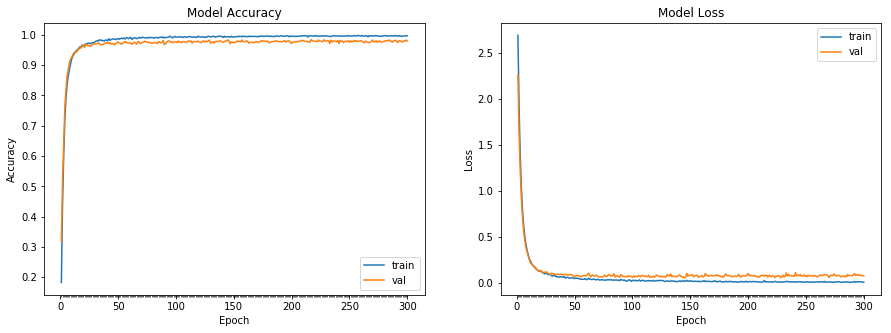

In [61]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

It's an improvement over our earlier model. Now, we'll try using Adam as our optimiser.'

In [62]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(19, activation='softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_score])

# Fit the model with increased batch size
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=300, batch_size=128)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 1s 228us/step - loss: 2.7299 - acc: 0.1847 - f1_score: 0.0048 - val_loss: 2.3961 - val_acc: 0.3199 - val_f1_score: 0.0459
Epoch 2/300
5836/5836 [==============================] - 0s 25us/step - loss: 2.1347 - acc: 0.4003 - f1_score: 0.0679 - val_loss: 1.8214 - val_acc: 0.4925 - val_f1_score: 0.1363
Epoch 3/300
5836/5836 [==============================] - 0s 24us/step - loss: 1.5860 - acc: 0.5584 - f1_score: 0.2238 - val_loss: 1.3646 - val_acc: 0.6178 - val_f1_score: 0.3062
Epoch 4/300
5836/5836 [==============================] - 0s 24us/step - loss: 1.1623 - acc: 0.6919 - f1_score: 0.3849 - val_loss: 1.0159 - val_acc: 0.7274 - val_f1_score: 0.4466
Epoch 5/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.8411 - acc: 0.7851 - f1_score: 0.5386 - val_loss: 0.7350 - val_acc: 0.8055 - val_f1_score: 0.6130
Epoch 6/300
5836/5836 [==============================] - 0s 2

Epoch 92/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0262 - acc: 0.9906 - f1_score: 0.9906 - val_loss: 0.0658 - val_acc: 0.9808 - val_f1_score: 0.9808
Epoch 93/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0214 - acc: 0.9931 - f1_score: 0.9928 - val_loss: 0.0644 - val_acc: 0.9849 - val_f1_score: 0.9842
Epoch 94/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0220 - acc: 0.9933 - f1_score: 0.9930 - val_loss: 0.0773 - val_acc: 0.9781 - val_f1_score: 0.9774
Epoch 95/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0223 - acc: 0.9943 - f1_score: 0.9940 - val_loss: 0.0643 - val_acc: 0.9801 - val_f1_score: 0.9795
Epoch 96/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0171 - acc: 0.9940 - f1_score: 0.9940 - val_loss: 0.0689 - val_acc: 0.9795 - val_f1_score: 0.9795
Epoch 97/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0171 - acc: 0.9950 - f1_

5836/5836 [==============================] - 0s 25us/step - loss: 0.0078 - acc: 0.9973 - f1_score: 0.9971 - val_loss: 0.0742 - val_acc: 0.9822 - val_f1_score: 0.9808
Epoch 183/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0087 - acc: 0.9971 - f1_score: 0.9971 - val_loss: 0.0787 - val_acc: 0.9822 - val_f1_score: 0.9822
Epoch 184/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0097 - acc: 0.9966 - f1_score: 0.9962 - val_loss: 0.0699 - val_acc: 0.9822 - val_f1_score: 0.9815
Epoch 185/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0125 - acc: 0.9967 - f1_score: 0.9962 - val_loss: 0.0894 - val_acc: 0.9808 - val_f1_score: 0.9801
Epoch 186/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0136 - acc: 0.9964 - f1_score: 0.9961 - val_loss: 0.0824 - val_acc: 0.9801 - val_f1_score: 0.9795
Epoch 187/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0088 - acc: 0.9967 - f1_score: 0

5836/5836 [==============================] - 0s 24us/step - loss: 0.0074 - acc: 0.9979 - f1_score: 0.9976 - val_loss: 0.0648 - val_acc: 0.9856 - val_f1_score: 0.9842
Epoch 273/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0124 - acc: 0.9969 - f1_score: 0.9969 - val_loss: 0.0834 - val_acc: 0.9808 - val_f1_score: 0.9808
Epoch 274/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0083 - acc: 0.9966 - f1_score: 0.9964 - val_loss: 0.0788 - val_acc: 0.9788 - val_f1_score: 0.9781
Epoch 275/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0116 - acc: 0.9967 - f1_score: 0.9966 - val_loss: 0.0983 - val_acc: 0.9753 - val_f1_score: 0.9747
Epoch 276/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0090 - acc: 0.9964 - f1_score: 0.9964 - val_loss: 0.0793 - val_acc: 0.9829 - val_f1_score: 0.9822
Epoch 277/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0111 - acc: 0.9964 - f1_score: 0

Model took 45.41 seconds to train


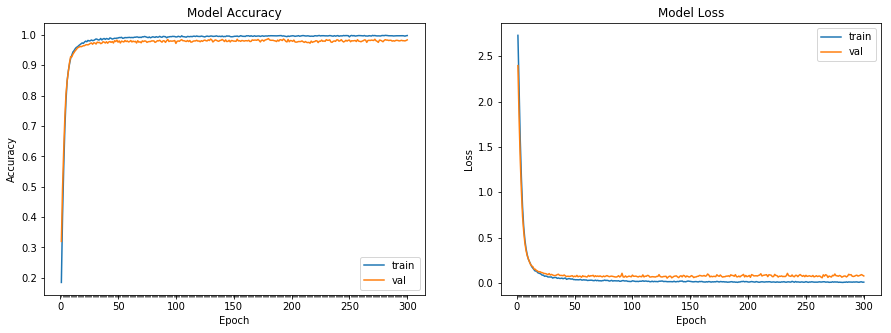

In [63]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

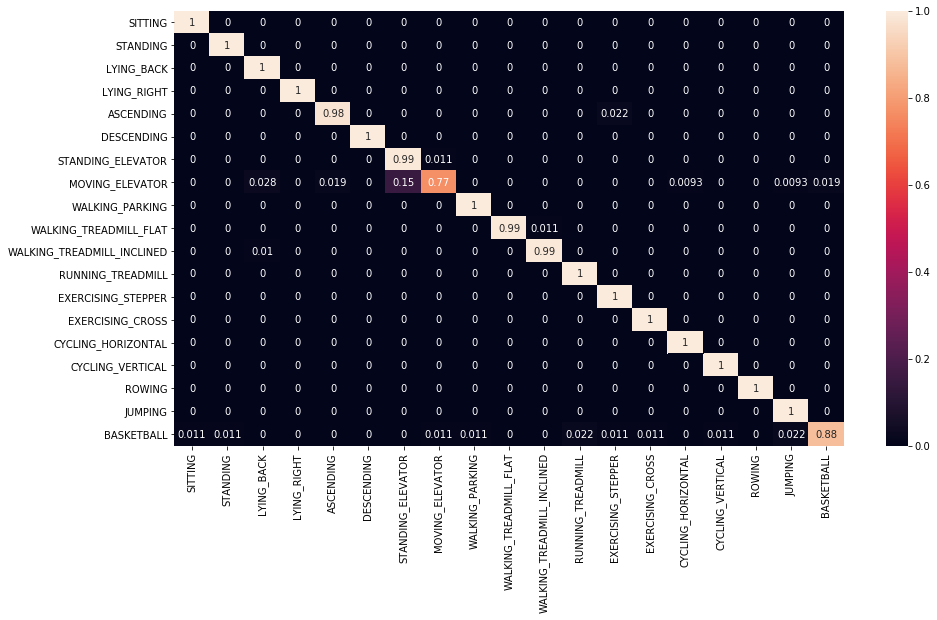

In [64]:
#predicting
prediction = np.argmax(model.predict(x = X_test, batch_size=128), axis=1)

#plotting
hmap(Y_test, prediction)

This has shown the best performance of all the models till now. Now we will use this last model with raw data.

**B. Raw data:**  

In [77]:
def expand_features2(df, label):
    '''Append the extracted fetures to each of the original 45 features'''
    data = df.T.values.tolist()
    
    n_row = df.T.shape[0] # should be 45 rows in transpose 
         
    data = np.array(data).flatten()
    data = data.tolist()
    data.append(label)
    return data

def transform_data2(activity_files, person_files, segment_files):
    '''loads data, extracts features, and transforms data'''
    player_data2 = defaultdict(list)
     # for activity_i
    for act_i, activity in enumerate(activity_files):
         act_i += 1
         # for person_j
         for per_i, person in enumerate(person_files):
            per_i += 1
             # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                 seg_i += 1
                 # load segment data
                 segment_path = path + activity + "/" + person + "/" + segment
                 # put data in dataframe
                 df = pd.read_csv(segment_path, header=None)
                 # feature expand 5 second segment 
                 expanded_data = expand_features2(df, act_i)
                 # each segment is now a row 
                 player_data2[per_i].append(expanded_data)   
    return player_data2

In [78]:
player_data2 = transform_data2(activity_files, person_files, segment_files)

In [79]:
np.array(player_data2[1]).shape

(1140, 5626)

In [80]:
x, y = seperate_data(player_data2)

Normalize features between $ 0 $ and $ 1 $:

In [81]:
scaled_data2 = np.array([minmax_scale(x[i]) for i in np.arange(0, 8, 1)])

In [82]:
x_hat = attach_user_data(scaled_data2)
y_hat = attach_user_data(Y)
 
print(x_hat.shape)
print(y_hat.shape)

(9120, 5625)
(9120,)


In [83]:
#split data into training and test set
x_train, x_test, Y_train, y_test = train_test_split(x_hat, y_hat, test_size=0.2, random_state=40)
#split training into training and validation set
x_train, x_val, Y_train, y_val = train_test_split(x_train, Y_train, test_size=0.2, random_state=40)

In [95]:
Y_train = adjust(Y_train)
y_test = adjust(y_test)
y_val = adjust(y_val)

Y_train2 = int_to_one_hot(Y_train)
Y_val2 = int_to_one_hot(y_val)
Y_test2 = int_to_one_hot(y_test)

In [96]:
model2 = Sequential()
model2.add(Dense(100, input_dim=5625, activation='relu'))
model2.add(Dropout(0.005))
model2.add(Dense(64, activation='relu'))
#model.add(Dropout(0.1))
model2.add(Dense(72, activation='relu'))
#model.add(Dropout(0.2))
model2.add(Dense(19, activation='softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_score])

# Fit the model with increased batch size
start = time.time()
model_info = model2.fit(x_train, Y_train2, validation_data=(x_val, Y_val2), 
          epochs=300, batch_size=128)
end = time.time()
 

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 2s 355us/step - loss: 2.5725 - acc: 0.2219 - f1_score: 0.0355 - val_loss: 1.9491 - val_acc: 0.4342 - val_f1_score: 0.1089
Epoch 2/300
5836/5836 [==============================] - 1s 195us/step - loss: 1.4812 - acc: 0.5567 - f1_score: 0.2113 - val_loss: 1.1562 - val_acc: 0.6110 - val_f1_score: 0.3356
Epoch 3/300
5836/5836 [==============================] - 1s 185us/step - loss: 0.9719 - acc: 0.6935 - f1_score: 0.4534 - val_loss: 0.9416 - val_acc: 0.7110 - val_f1_score: 0.5199
Epoch 4/300
5836/5836 [==============================] - 1s 184us/step - loss: 0.7538 - acc: 0.7587 - f1_score: 0.6148 - val_loss: 0.7475 - val_acc: 0.7562 - val_f1_score: 0.6260
Epoch 5/300
5836/5836 [==============================] - 1s 196us/step - loss: 0.6178 - acc: 0.7975 - f1_score: 0.6837 - val_loss: 0.5520 - val_acc: 0.8164 - val_f1_score: 0.7418
Epoch 6/300
5836/5836 [==============================] - 

5836/5836 [==============================] - 1s 185us/step - loss: 0.0343 - acc: 0.9873 - f1_score: 0.9871 - val_loss: 0.1112 - val_acc: 0.9658 - val_f1_score: 0.9658
Epoch 92/300
5836/5836 [==============================] - 1s 247us/step - loss: 0.0426 - acc: 0.9853 - f1_score: 0.9846 - val_loss: 0.1213 - val_acc: 0.9603 - val_f1_score: 0.9596
Epoch 93/300
5836/5836 [==============================] - 1s 174us/step - loss: 0.0394 - acc: 0.9875 - f1_score: 0.9875 - val_loss: 0.1485 - val_acc: 0.9527 - val_f1_score: 0.9521
Epoch 94/300
5836/5836 [==============================] - 1s 188us/step - loss: 0.0281 - acc: 0.9901 - f1_score: 0.9901 - val_loss: 0.0815 - val_acc: 0.9760 - val_f1_score: 0.9753
Epoch 95/300
5836/5836 [==============================] - 1s 217us/step - loss: 0.0604 - acc: 0.9801 - f1_score: 0.9796 - val_loss: 0.1504 - val_acc: 0.9541 - val_f1_score: 0.9534
Epoch 96/300
5836/5836 [==============================] - 1s 203us/step - loss: 0.0553 - acc: 0.9808 - f1_score: 

5836/5836 [==============================] - 1s 177us/step - loss: 0.0225 - acc: 0.9913 - f1_score: 0.9913 - val_loss: 0.0958 - val_acc: 0.9774 - val_f1_score: 0.9774
Epoch 182/300
5836/5836 [==============================] - 1s 175us/step - loss: 0.0187 - acc: 0.9930 - f1_score: 0.9928 - val_loss: 0.1365 - val_acc: 0.9699 - val_f1_score: 0.9699
Epoch 183/300
5836/5836 [==============================] - 1s 182us/step - loss: 0.0246 - acc: 0.9909 - f1_score: 0.9907 - val_loss: 0.1424 - val_acc: 0.9610 - val_f1_score: 0.9603
Epoch 184/300
5836/5836 [==============================] - 1s 182us/step - loss: 0.0352 - acc: 0.9880 - f1_score: 0.9878 - val_loss: 0.0899 - val_acc: 0.9774 - val_f1_score: 0.9774
Epoch 185/300
5836/5836 [==============================] - 1s 194us/step - loss: 0.0302 - acc: 0.9892 - f1_score: 0.9892 - val_loss: 0.1389 - val_acc: 0.9671 - val_f1_score: 0.9664
Epoch 186/300
5836/5836 [==============================] - 1s 214us/step - loss: 0.0222 - acc: 0.9919 - f1_sc

5836/5836 [==============================] - 1s 183us/step - loss: 0.0276 - acc: 0.9909 - f1_score: 0.9909 - val_loss: 0.1438 - val_acc: 0.9678 - val_f1_score: 0.9671
Epoch 272/300
5836/5836 [==============================] - 1s 197us/step - loss: 0.0275 - acc: 0.9902 - f1_score: 0.9902 - val_loss: 0.1233 - val_acc: 0.9781 - val_f1_score: 0.9781
Epoch 273/300
5836/5836 [==============================] - 1s 180us/step - loss: 0.0149 - acc: 0.9942 - f1_score: 0.9942 - val_loss: 0.1299 - val_acc: 0.9685 - val_f1_score: 0.9685
Epoch 274/300
5836/5836 [==============================] - 1s 183us/step - loss: 0.0130 - acc: 0.9945 - f1_score: 0.9945 - val_loss: 0.0920 - val_acc: 0.9760 - val_f1_score: 0.9760
Epoch 275/300
5836/5836 [==============================] - 1s 190us/step - loss: 0.0110 - acc: 0.9961 - f1_score: 0.9957 - val_loss: 0.1004 - val_acc: 0.9747 - val_f1_score: 0.9747
Epoch 276/300
5836/5836 [==============================] - 1s 182us/step - loss: 0.0164 - acc: 0.9945 - f1_sc

Model took 333.69 seconds to train


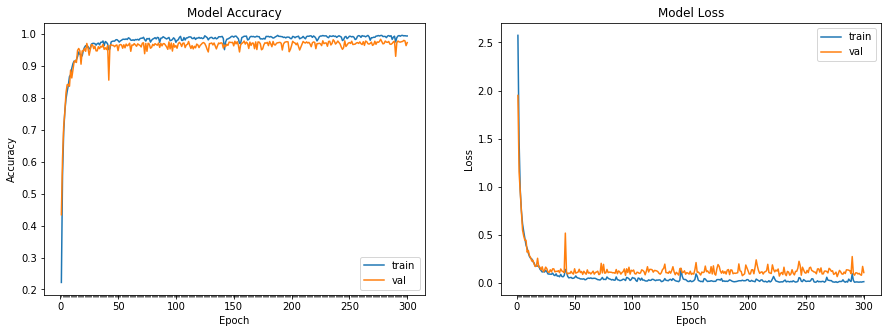

In [97]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

We see that using the raw data completely takes up a lot of time for training with quite a few spikes compared to when we had used feature engineering.

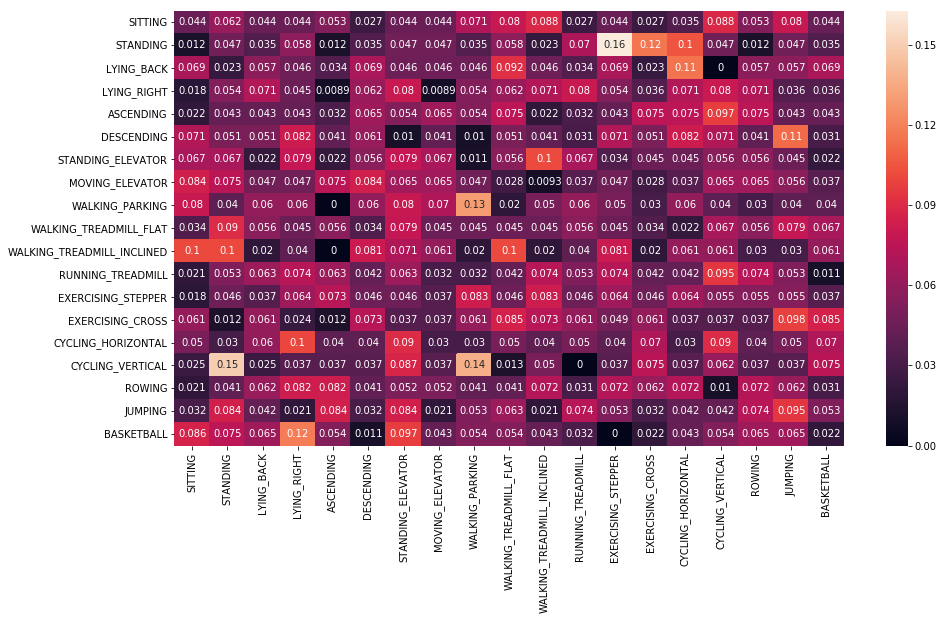

In [99]:
#predicting
prediction = np.argmax(model2.predict(x = x_test, batch_size=128), axis=1)

#plotting
hmap(Y_test, prediction)

# Predicting activity with subject wise data as discriminator

We will now do the second part of the project.


# Data

We will now have a brief look at the file structure of this reverse project.

**File structure: **    
8 subjects (p)   
19 activities (a) (in the order given above) 
60 segments (s)   
5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL)   
9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers)

Here, we have 8 subject folders first. Each of the subject has 19 sub-folders representing the 19 activities he/she performs. Each activity has the respective signal segments.

We will now do feature engineering and transform the data into suitable format as seen earlier.

In [100]:
#Returns the autocorralation for each of the original 45 features
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

#Returns the extracted features for each of the original 45 features
def get_segment_features(data):
    mean = np.mean(data)
    std = np.std(data)
    kurtosis = stats.kurtosis(data)
    skew = stats.skew(data)
    autocorr_vals = autocorr(data)[0:10].tolist()
    n_max_peaks = 5 # get top n max points to include to features
    n_outlier = 0 # first point is always a large and non-characteristic of the transform
    max_peaks_fft = np.sort(rfft(data))[:-n_outlier][-n_max_peaks:].tolist()
    
    max_peaks_fft.extend([mean, std, skew, kurtosis])
    max_peaks_fft.extend(autocorr_vals)
    
    return max_peaks_fft

#Append the extracted fetures to each of the original 45 features
def expand_features(df, label):
    data = df.T.values.tolist()
    extracted_features = [get_segment_features(row) for row in data]
    
    n_row = df.T.shape[0] # should be 45 rows in transpose 
    for row_i in range(n_row):
        data[row_i].extend(extracted_features[row_i])
        
    data = np.array(data).flatten()
    data = data.tolist()
    data.append(label)
    return data

#Creates activity file names
def get_activity_files_names():
    activity_files = []
    for num in np.arange(1,20,1):
        if num < 10:
            activity_files.append("a0{}".format(num))
        else:
            activity_files.append("a{}".format(num))
    return activity_files

#Creates segment file names
def get_segment_files_names():
    segment_files = []
    for num in np.arange(1,61,1):
        if num < 10:
            segment_files.append("s0{}.txt".format(num))
        else:
            segment_files.append("s{}.txt".format(num))
    return segment_files

#loads data, extracts features, and transforms data
def transform_data(activity_files, person_files, segment_files):
    player_data = defaultdict(list)
    # for person_i
    for per_i, person in enumerate(person_files):
        per_i += 1
        # for activity_j
        for act_i, activity in enumerate(activity_files):
            act_i += 1
            # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                seg_i += 1
                # load segment data
                segment_path = path + person + "/" + activity + "/" + segment
                # put data in dataframe
                df = pd.read_csv(segment_path, header=None)
                # feature expand 5 second segment 
                expanded_data = expand_features(df, per_i)
                # each segment is now a row 
                player_data[per_i].append(expanded_data)   
    return player_data

In [101]:
activity_files = get_activity_files_names()
activity_files[0:5]

['a01', 'a02', 'a03', 'a04', 'a05']

In [102]:
segment_files =  get_segment_files_names()
segment_files[0:5]

['s01.txt', 's02.txt', 's03.txt', 's04.txt', 's05.txt']

In [103]:
person_files = ["p{}".format(num) for num in np.arange(1,9,1)]
person_files

['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']

In [104]:
path = "../input/reverse-har/data2/data2/"
player_data = transform_data(activity_files, person_files, segment_files)

In [105]:
#Create the predictor and response data for each player
def separate_data(player_data):
    Y = []
    X = []
    for player_i in player_data.keys():
        x_temp = []
        y_temp = []

        for row in player_data[player_i]:
            y_temp.append(row[-1])
            x_temp.append(row[:-1])

        Y.append(y_temp)
        X.append(x_temp)

    Y = np.array(Y)
    X = np.array(X)
    return X, Y

In [106]:
X, Y = separate_data(player_data)

In [108]:
print(X.shape)
print(Y.shape)

(8, 1140, 6255)
(8, 1140)


In [109]:
print(X[0])#signals
print(Y[0])#people

[[  8.13   8.13   8.16 ...,   0.38   0.38   0.38]
 [  7.97   7.95   7.99 ...,   0.39   0.38   0.38]
 [  7.89   7.91   7.87 ...,   0.38   0.38   0.38]
 ..., 
 [  0.6    5.36   6.77 ...,  19.09  18.77  18.46]
 [  7.77   9.72   8.83 ...,  16.95  16.31  15.63]
 [ 12.     8.39   7.97 ...,   6.42   6.23   6.05]]
[1 1 1 ..., 1 1 1]


Normalizing the values

In [110]:
scaled_data = np.array([minmax_scale(X[i]) for i in np.arange(0, 8, 1)])

Applying PCA

In [111]:
pca = PCA()
# fit pca to the data of a single player for visual purposes
pca.fit(scaled_data[0]);

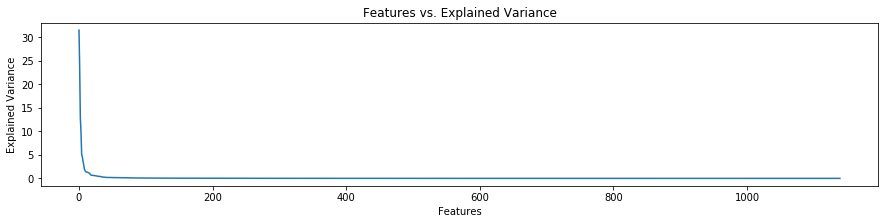

In [112]:
plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_);

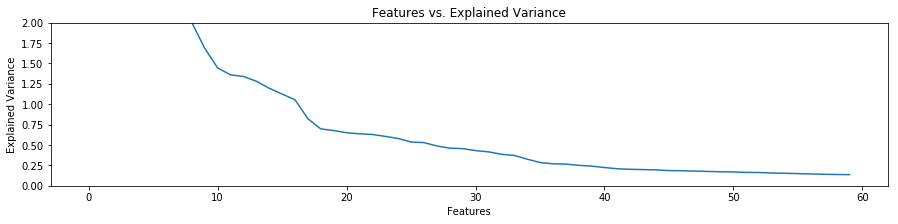

In [113]:
plt.figure(figsize = (15, 3))
plt.title("Features vs. Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Features")
plt.plot(pca.explained_variance_[:60]);
plt.ylim(0,2);

In [114]:
pca = PCA(n_components=30)
reduced_data = np.array([pca.fit_transform(person_i) for person_i in scaled_data])

In [115]:
reduced_data.shape

(8, 1140, 30)

In [116]:
def attach_user_data(lst):
    #concatenate user data
    data = []
    for row in lst:
        data.extend(row)
    return np.array(data)

X_clean = attach_user_data(reduced_data)
Y_clean = attach_user_data(Y)

print(X_clean.shape)
print(Y_clean.shape)

(9120, 30)
(9120,)


In [117]:
#splitting into test and training sets
X_train, X_test, Y_train, Y_test  = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=36)
#splitting into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=36)

In [124]:
print(X_test.shape)

(1824, 30)


In [128]:
Y_train = adjust(Y_train)
Y_test = adjust(Y_test)
Y_val = adjust(Y_val)

#one hot encodings
Y_train2 = int_to_one_hot(Y_train)
Y_val2 = int_to_one_hot(Y_val)
Y_test2 = int_to_one_hot(Y_test)
    

In [129]:
#create the model
model = Sequential()
model.add(Dense(30, input_dim=30, activation='relu'))
model.add(Dropout(0.005))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(72, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
 
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_score])

# Fit the model with increased batch size
start = time.time()
model_info = model.fit(X_train, Y_train2, validation_data=(X_val, Y_val2), 
          epochs=300, batch_size=128)
end = time.time()

Train on 5836 samples, validate on 1460 samples
Epoch 1/300
5836/5836 [==============================] - 1s 169us/step - loss: 2.0195 - acc: 0.2411 - f1_score: 0.0000e+00 - val_loss: 1.8970 - val_acc: 0.3418 - val_f1_score: 0.0000e+00
Epoch 2/300
5836/5836 [==============================] - 0s 25us/step - loss: 1.7775 - acc: 0.4292 - f1_score: 0.0045 - val_loss: 1.6728 - val_acc: 0.4808 - val_f1_score: 0.0137
Epoch 3/300
5836/5836 [==============================] - 0s 28us/step - loss: 1.5135 - acc: 0.5737 - f1_score: 0.0449 - val_loss: 1.3799 - val_acc: 0.6390 - val_f1_score: 0.0966
Epoch 4/300
5836/5836 [==============================] - 0s 24us/step - loss: 1.1969 - acc: 0.7003 - f1_score: 0.1952 - val_loss: 1.0602 - val_acc: 0.7452 - val_f1_score: 0.3075
Epoch 5/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.8702 - acc: 0.8141 - f1_score: 0.4536 - val_loss: 0.7666 - val_acc: 0.8370 - val_f1_score: 0.5630
Epoch 6/300
5836/5836 [==============================

Epoch 92/300
5836/5836 [==============================] - 0s 24us/step - loss: 0.0095 - acc: 0.9971 - f1_score: 0.9971 - val_loss: 0.0645 - val_acc: 0.9856 - val_f1_score: 0.9849
Epoch 93/300
5836/5836 [==============================] - 0s 27us/step - loss: 0.0123 - acc: 0.9957 - f1_score: 0.9955 - val_loss: 0.0677 - val_acc: 0.9856 - val_f1_score: 0.9842
Epoch 94/300
5836/5836 [==============================] - 0s 27us/step - loss: 0.0098 - acc: 0.9971 - f1_score: 0.9969 - val_loss: 0.0626 - val_acc: 0.9856 - val_f1_score: 0.9842
Epoch 95/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0122 - acc: 0.9964 - f1_score: 0.9964 - val_loss: 0.0681 - val_acc: 0.9863 - val_f1_score: 0.9863
Epoch 96/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0129 - acc: 0.9966 - f1_score: 0.9964 - val_loss: 0.0621 - val_acc: 0.9870 - val_f1_score: 0.9856
Epoch 97/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0113 - acc: 0.9971 - f1_

5836/5836 [==============================] - 0s 25us/step - loss: 0.0081 - acc: 0.9978 - f1_score: 0.9976 - val_loss: 0.1031 - val_acc: 0.9808 - val_f1_score: 0.9808
Epoch 183/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0073 - acc: 0.9973 - f1_score: 0.9973 - val_loss: 0.0763 - val_acc: 0.9877 - val_f1_score: 0.9870
Epoch 184/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0083 - acc: 0.9979 - f1_score: 0.9979 - val_loss: 0.0751 - val_acc: 0.9863 - val_f1_score: 0.9863
Epoch 185/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0050 - acc: 0.9985 - f1_score: 0.9981 - val_loss: 0.0757 - val_acc: 0.9863 - val_f1_score: 0.9863
Epoch 186/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0043 - acc: 0.9990 - f1_score: 0.9988 - val_loss: 0.0848 - val_acc: 0.9836 - val_f1_score: 0.9822
Epoch 187/300
5836/5836 [==============================] - 0s 28us/step - loss: 0.0039 - acc: 0.9990 - f1_score: 0

5836/5836 [==============================] - 0s 25us/step - loss: 0.0066 - acc: 0.9981 - f1_score: 0.9981 - val_loss: 0.0764 - val_acc: 0.9877 - val_f1_score: 0.9877
Epoch 273/300
5836/5836 [==============================] - 0s 23us/step - loss: 0.0064 - acc: 0.9978 - f1_score: 0.9978 - val_loss: 0.0700 - val_acc: 0.9897 - val_f1_score: 0.9897
Epoch 274/300
5836/5836 [==============================] - 0s 26us/step - loss: 0.0061 - acc: 0.9986 - f1_score: 0.9986 - val_loss: 0.0670 - val_acc: 0.9890 - val_f1_score: 0.9884
Epoch 275/300
5836/5836 [==============================] - 0s 27us/step - loss: 0.0056 - acc: 0.9985 - f1_score: 0.9985 - val_loss: 0.0636 - val_acc: 0.9904 - val_f1_score: 0.9897
Epoch 276/300
5836/5836 [==============================] - 0s 27us/step - loss: 0.0015 - acc: 0.9997 - f1_score: 0.9997 - val_loss: 0.0676 - val_acc: 0.9890 - val_f1_score: 0.9890
Epoch 277/300
5836/5836 [==============================] - 0s 25us/step - loss: 0.0022 - acc: 0.9991 - f1_score: 0

Model took 46.28 seconds to train


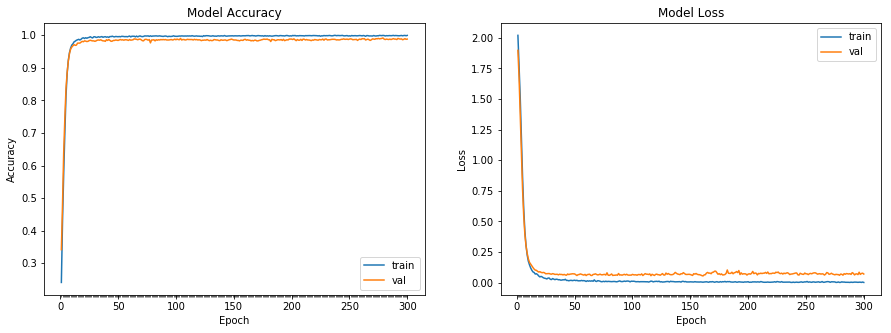

In [130]:
#time taken
print("Model took %0.2f seconds to train"%(end - start))

#plotting model
plot_model_history(model_info)

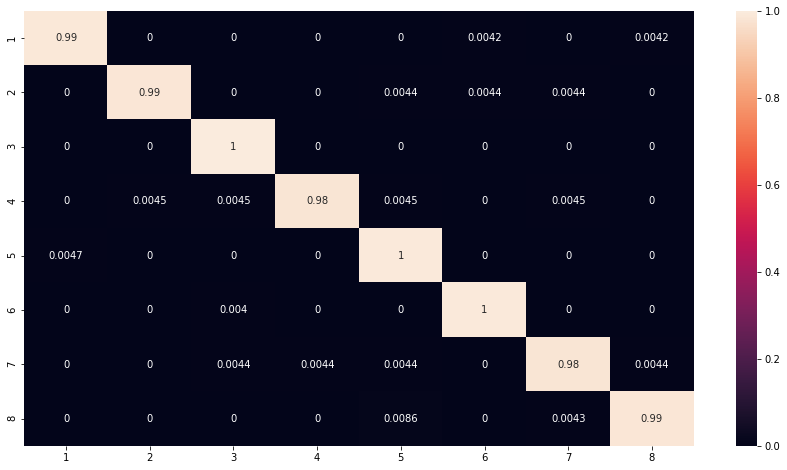

In [133]:
#predicting
prediction = np.argmax(model.predict(x = X_test, batch_size=128), axis=1)

#plotting
cm = confusion_matrix(Y_test, prediction)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) #normalization
np.set_printoptions(precision=2)
df_cm = pd.DataFrame(cm, index = [i for i in [1,2,3,4,5,6,7,8]],
                  columns = [i for i in [1,2,3,4,5,6,7,8]])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)

# Conclusion:

We have seen how an understanding of time series data and signal processing can lead to engineering features and building machine learning models that predict which activity users are engaged in and also which subject an activity belongs to with high accuracy.  


# References:
1. M.C.Yuksek and B.Barshan,"Human Activity Classification With Miniature Inertial and Magnetic Sensor Signals",  *European Signal Processing Conference *,   2011
2. B.Barshan and M.C.Yuksek, " Recognizing Daily and Sports Activities in Two Open Source Machine Learning Environments Using Body-Worn Sensor Units", *The Computer Journal, 57(11):1649--1667*, November 2014.